In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

Dataset shape: (1649, 22)
       Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   

   Polio  Total expenditure  Diphtheria    HIV/AIDS         

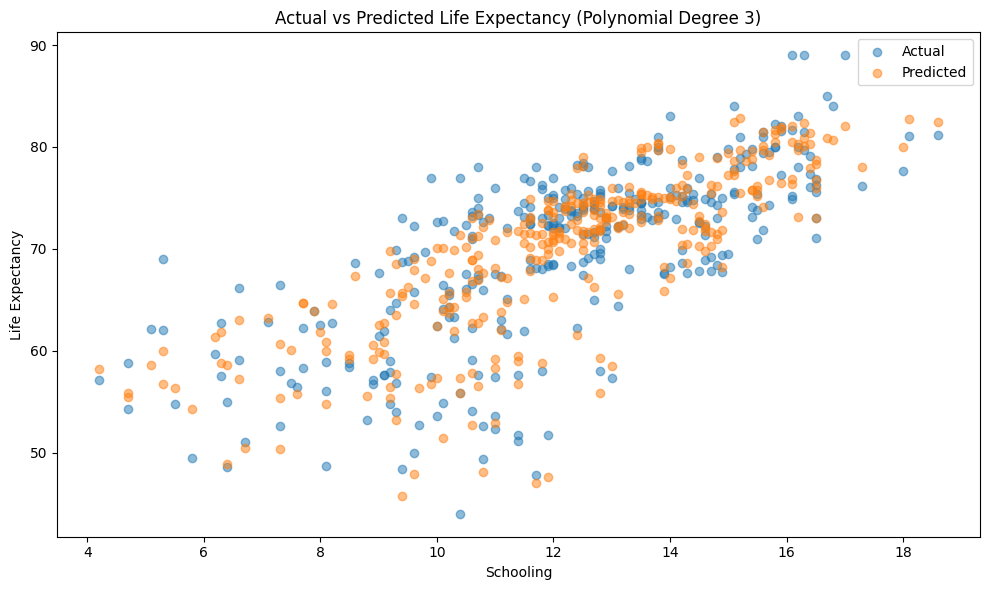


--- POLYNOMIAL CLASSIFICATION ---

Polynomial Degree 1:
  Accuracy: 0.8909
  CV Accuracy: 0.8781
Polynomial Degree 2:
  Accuracy: 0.8909
  CV Accuracy: 0.8721
Polynomial Degree 3:
  Accuracy: 0.8939
  CV Accuracy: 0.8769

Best polynomial degree for classification: 1

Classification Report:
              precision    recall  f1-score   support

  Developing       0.90      0.98      0.94       282
   Developed       0.73      0.40      0.51        48

    accuracy                           0.89       330
   macro avg       0.82      0.69      0.73       330
weighted avg       0.88      0.89      0.88       330


Comparison with Random Forest (non-polynomial model):
Random Forest Accuracy: 0.9455


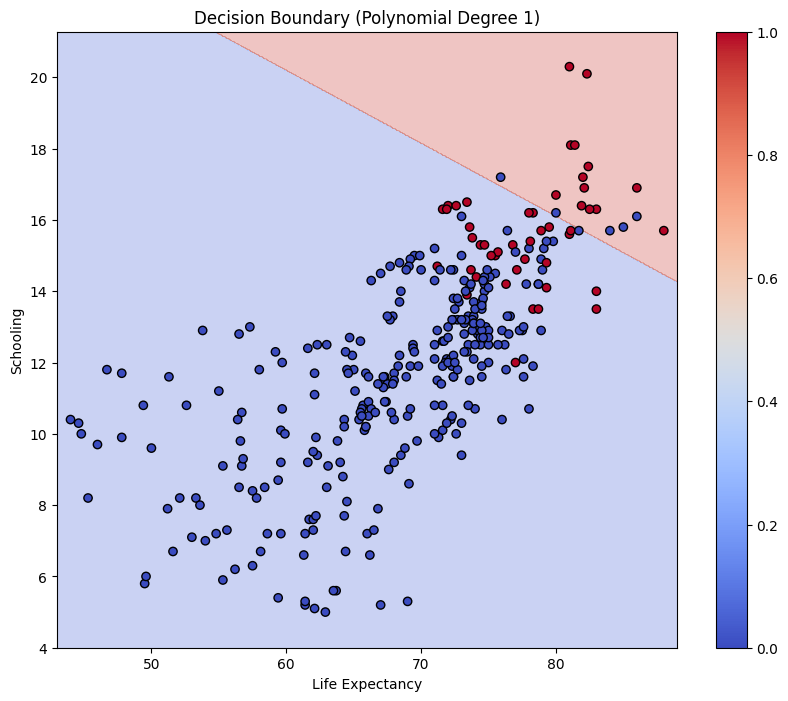


--- CONCLUSION ---

Best polynomial regression model (degree 3):
  R² Score: 0.8828
  MSE: 8.3250

Best polynomial classification model (degree 1):
  Accuracy: 0.8939
  CV Accuracy: 0.8781


In [ ]:
# Load the dataset
# Note: In a real scenario, you would use window.fs.readFile to load the CSV
# For this example, we'll assume the CSV is loaded as follows:
df = pd.read_csv('Life Expectancy Data.csv')

# Data preparation
df = df.dropna()  # Remove rows with missing values

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(df.head())

# ---------------------------------------------
# PART 1: POLYNOMIAL REGRESSION
# ---------------------------------------------
print("\n--- POLYNOMIAL REGRESSION ---\n")

# For regression task: Predict life expectancy
# Let's select some features that might influence life expectancy
features = ['Adult Mortality', 'Income composition of resources', 'Schooling', 'GDP']
X = df[features]
y = df['Life expectancy ']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a scaler object
scaler = StandardScaler()

# Function to evaluate different polynomial degrees
def evaluate_polynomial_regression(max_degree=3):
    results = []

    for degree in range(1, max_degree + 1):
        # Create a pipeline with polynomial features, scaling, and linear regression
        pipeline = Pipeline([
            ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
            ('scaler', StandardScaler()),
            ('regression', LinearRegression())
        ])

        # Train the model
        pipeline.fit(X_train, y_train)

        # Make predictions
        y_pred = pipeline.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results.append({
            'degree': degree,
            'mse': mse,
            'r2': r2
        })

        print(f"Polynomial Degree {degree}:")
        print(f"  MSE: {mse:.4f}")
        print(f"  R²: {r2:.4f}")

    return results

# Evaluate models with different polynomial degrees
poly_results = evaluate_polynomial_regression(max_degree=3)

# Find the best model
best_degree = max(poly_results, key=lambda x: x['r2'])['degree']
print(f"\nBest polynomial degree for regression: {best_degree}")

# Create and train the best model
best_poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regression', LinearRegression())
])
best_poly_model.fit(X_train, y_train)

# Feature importance for the best model (for linear terms)
poly = best_poly_model.named_steps['poly']
regression = best_poly_model.named_steps['regression']
feature_names = poly.get_feature_names_out(X.columns)
coefficients = pd.DataFrame(regression.coef_, columns=['Coefficient'], index=feature_names)
print("\nTop 10 polynomial features by coefficient magnitude:")
print(coefficients.abs().sort_values('Coefficient', ascending=False).head(10))

# Visualize predictions vs actual (for a single feature, for visualization)
plt.figure(figsize=(10, 6))
plt.scatter(X_test['Schooling'], y_test, alpha=0.5, label='Actual')
plt.scatter(X_test['Schooling'], best_poly_model.predict(X_test), alpha=0.5, label='Predicted')
plt.xlabel('Schooling')
plt.ylabel('Life Expectancy')
plt.title(f'Actual vs Predicted Life Expectancy (Polynomial Degree {best_degree})')
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------------
# PART 2: POLYNOMIAL CLASSIFICATION
# ---------------------------------------------
print("\n--- POLYNOMIAL CLASSIFICATION ---\n")

# For classification task: Predict development status (Developed vs Developing)
# Create binary target
df['Status_Binary'] = df['Status'].apply(lambda x: 1 if x == 'Developed' else 0)

# Select features
X_clf = df[['Life expectancy ', 'Adult Mortality', 'GDP', 'Schooling']]
y_clf = df['Status_Binary']

# Split the data
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# Function to evaluate different polynomial degrees for classification
def evaluate_polynomial_classification(max_degree=3):
    results = []

    for degree in range(1, max_degree + 1):
        # Create a pipeline with polynomial features, scaling, and logistic regression
        pipeline = Pipeline([
            ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(max_iter=1000, random_state=42))
        ])

        # Train the model
        pipeline.fit(X_train_clf, y_train_clf)

        # Make predictions
        y_pred_clf = pipeline.predict(X_test_clf)

        # Calculate metrics
        accuracy = accuracy_score(y_test_clf, y_pred_clf)

        # Cross-validation score
        cv_scores = cross_val_score(pipeline, X_clf, y_clf, cv=5, scoring='accuracy')

        results.append({
            'degree': degree,
            'accuracy': accuracy,
            'cv_accuracy': np.mean(cv_scores)
        })

        print(f"Polynomial Degree {degree}:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  CV Accuracy: {np.mean(cv_scores):.4f}")

    return results

# Evaluate classification models with different polynomial degrees
poly_clf_results = evaluate_polynomial_classification(max_degree=3)

# Find the best model
best_degree_clf = max(poly_clf_results, key=lambda x: x['cv_accuracy'])['degree']
print(f"\nBest polynomial degree for classification: {best_degree_clf}")

# Create and train the best classification model
best_poly_clf_model = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree_clf, include_bias=False)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
best_poly_clf_model.fit(X_train_clf, y_train_clf)

# Evaluate on test set
y_pred_clf = best_poly_clf_model.predict(X_test_clf)
print("\nClassification Report:")
print(classification_report(y_test_clf, y_pred_clf, target_names=['Developing', 'Developed']))

# Compare with a non-polynomial model (Random Forest) for reference
print("\nComparison with Random Forest (non-polynomial model):")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_clf, y_train_clf)
y_pred_rf = rf_model.predict(X_test_clf)
rf_accuracy = accuracy_score(y_test_clf, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Display decision boundary (for two features only, for visualization)
def plot_decision_boundary(model, X, y, feature_idx=(0, 1), feature_names=None):
    # Extract the two features for plotting
    X_plot = X.iloc[:, list(feature_idx)]  # Use list for proper indexing
    feature_names = feature_names or [X.columns[i] for i in feature_idx]

    # Create a mesh grid
    h = 0.02  # mesh step size
    x_min, x_max = X_plot.iloc[:, 0].min() - 1, X_plot.iloc[:, 0].max() + 1
    y_min, y_max = X_plot.iloc[:, 1].min() - 1, X_plot.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Create a DataFrame with all features, using mean values for non-plotted features
    means = X.mean().values
    mesh_points = np.zeros((xx.ravel().shape[0], X.shape[1]))
    for i in range(X.shape[1]):
        if i not in feature_idx:
            mesh_points[:, i] = means[i]

    mesh_points[:, feature_idx[0]] = xx.ravel()
    mesh_points[:, feature_idx[1]] = yy.ravel()

    # Predict
    Z = model.predict(pd.DataFrame(mesh_points, columns=X.columns))
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X_plot.iloc[:, 0], X_plot.iloc[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(f'Decision Boundary (Polynomial Degree {best_degree_clf})')
    plt.colorbar()
    plt.show()

# Plot decision boundary for Life expectancy vs Schooling (using simpler approach)
# Extract the features we want to plot
X_viz = X_test_clf[['Life expectancy ', 'Schooling']]

# Create a mesh grid
h = 0.02  # mesh step size
x_min, x_max = X_viz['Life expectancy '].min() - 1, X_viz['Life expectancy '].max() + 1
y_min, y_max = X_viz['Schooling'].min() - 1, X_viz['Schooling'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Create test points
# For missing features, we'll use the mean values from the training set
mean_values = X_test_clf.mean()
test_points = []

for i in range(len(xx.ravel())):
    point = mean_values.copy()
    point['Life expectancy '] = xx.ravel()[i]
    point['Schooling'] = yy.ravel()[i]
    test_points.append(point)

test_df = pd.DataFrame(test_points)

# Predict class for each point
Z = best_poly_clf_model.predict(test_df)
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X_test_clf['Life expectancy '], X_test_clf['Schooling'], c=y_test_clf,
            cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlabel('Life Expectancy')
plt.ylabel('Schooling')
plt.title(f'Decision Boundary (Polynomial Degree {best_degree_clf})')
plt.colorbar()
plt.show()

# ---------------------------------------------
# CONCLUSION
# ---------------------------------------------
print("\n--- CONCLUSION ---\n")
print(f"Best polynomial regression model (degree {best_degree}):")
print(f"  R² Score: {max(poly_results, key=lambda x: x['r2'])['r2']:.4f}")
print(f"  MSE: {min(poly_results, key=lambda x: x['mse'])['mse']:.4f}")

print(f"\nBest polynomial classification model (degree {best_degree_clf}):")
print(f"  Accuracy: {max(poly_clf_results, key=lambda x: x['accuracy'])['accuracy']:.4f}")
print(f"  CV Accuracy: {max(poly_clf_results, key=lambda x: x['cv_accuracy'])['cv_accuracy']:.4f}")

Loading and preprocessing data...
Dataset shape: (2938, 22)

First 5 rows:
       Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   

   Polio  T

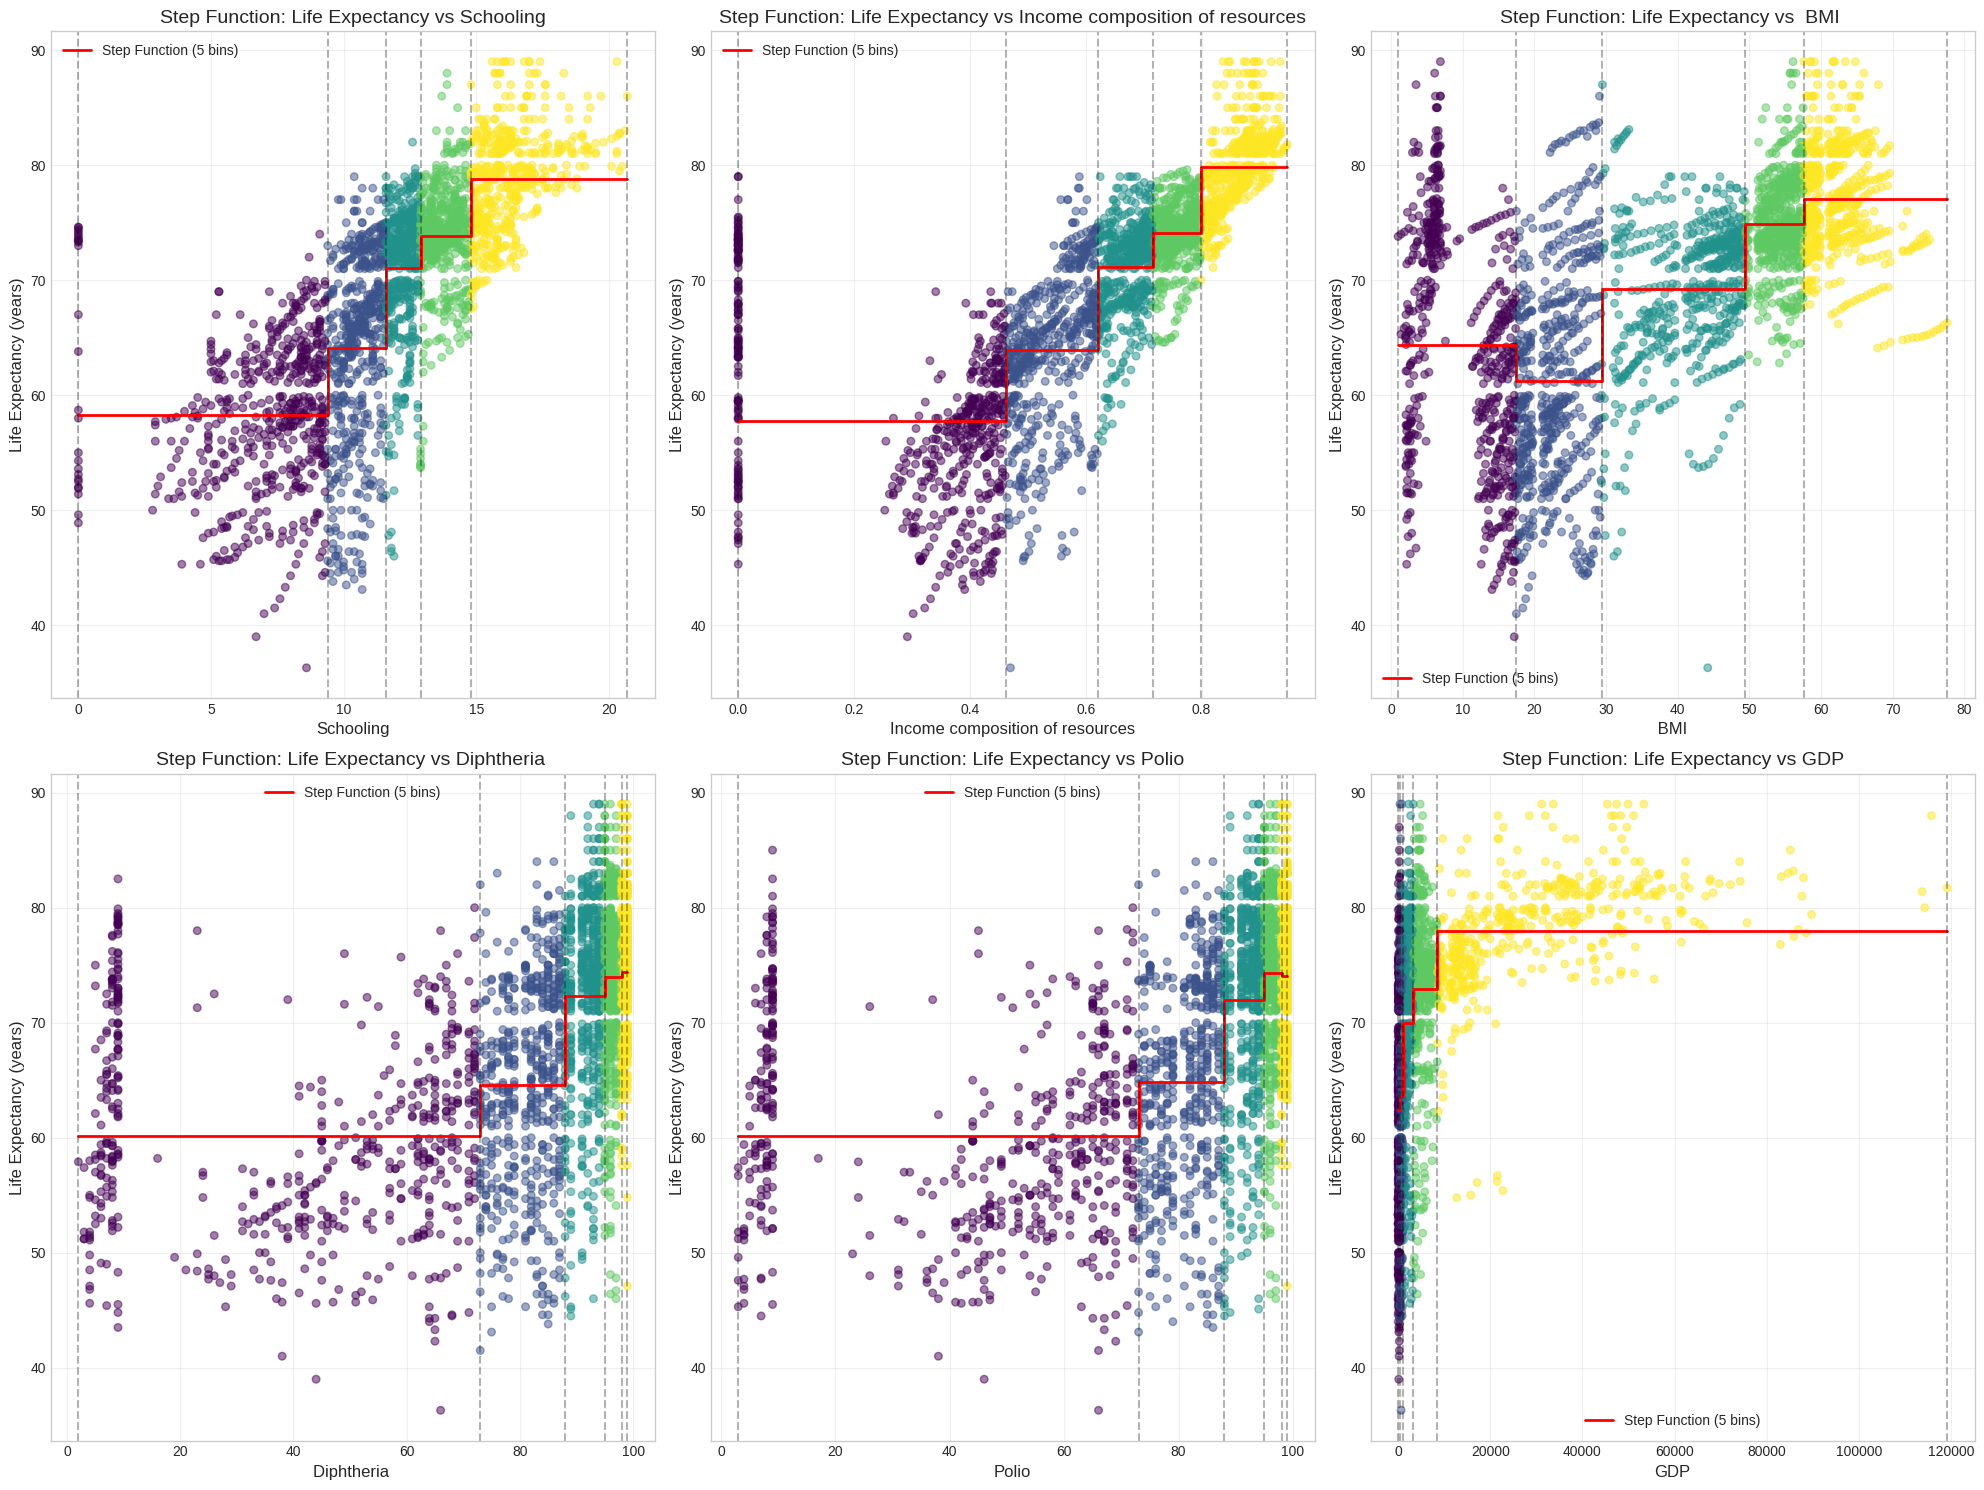


Preparing data for modeling...

Creating preprocessing pipeline...

Building step function models...

Step Function with 3 bins:

Linear Regression with Step Functions:
Train RMSE: 4.4120
Test RMSE: 4.2736
Train MAE: 3.3093
Test MAE: 3.2147
Train R²: 0.7877
Test R²: 0.7889

Ridge Regression with Step Functions (3 bins):
Train RMSE: 4.4120
Test RMSE: 4.2738
Train MAE: 3.3089
Test MAE: 3.2153
Train R²: 0.7877
Test R²: 0.7888

Step Function with 5 bins:

Linear Regression with Step Functions:
Train RMSE: 3.5592
Test RMSE: 3.5131
Train MAE: 2.6440
Test MAE: 2.6608
Train R²: 0.8618
Test R²: 0.8573

Ridge Regression with Step Functions (5 bins):
Train RMSE: 3.5593
Test RMSE: 3.5137
Train MAE: 2.6435
Test MAE: 2.6608
Train R²: 0.8618
Test R²: 0.8573

Step Function with 7 bins:

Linear Regression with Step Functions:
Train RMSE: 3.4332
Test RMSE: 3.3705
Train MAE: 2.5254
Test MAE: 2.5097
Train R²: 0.8714
Test R²: 0.8687

Ridge Regression with Step Functions (7 bins):
Train RMSE: 3.4333
Test R

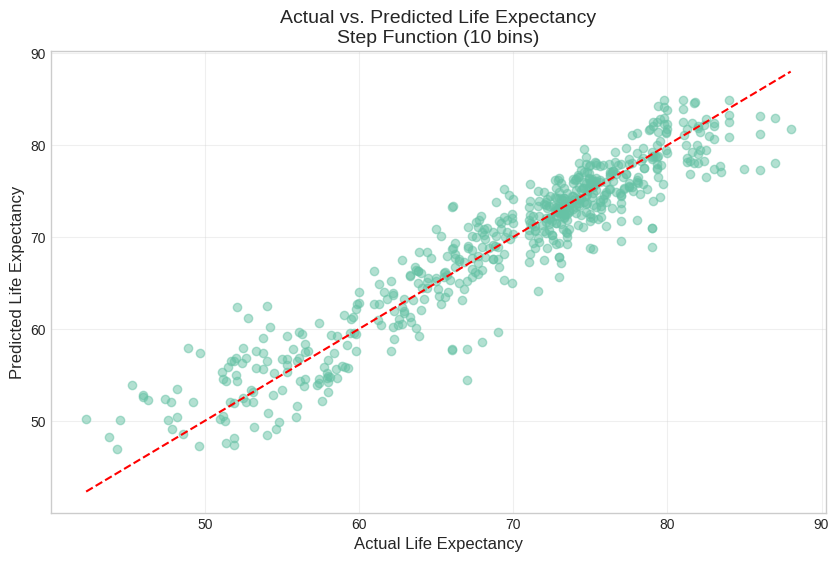

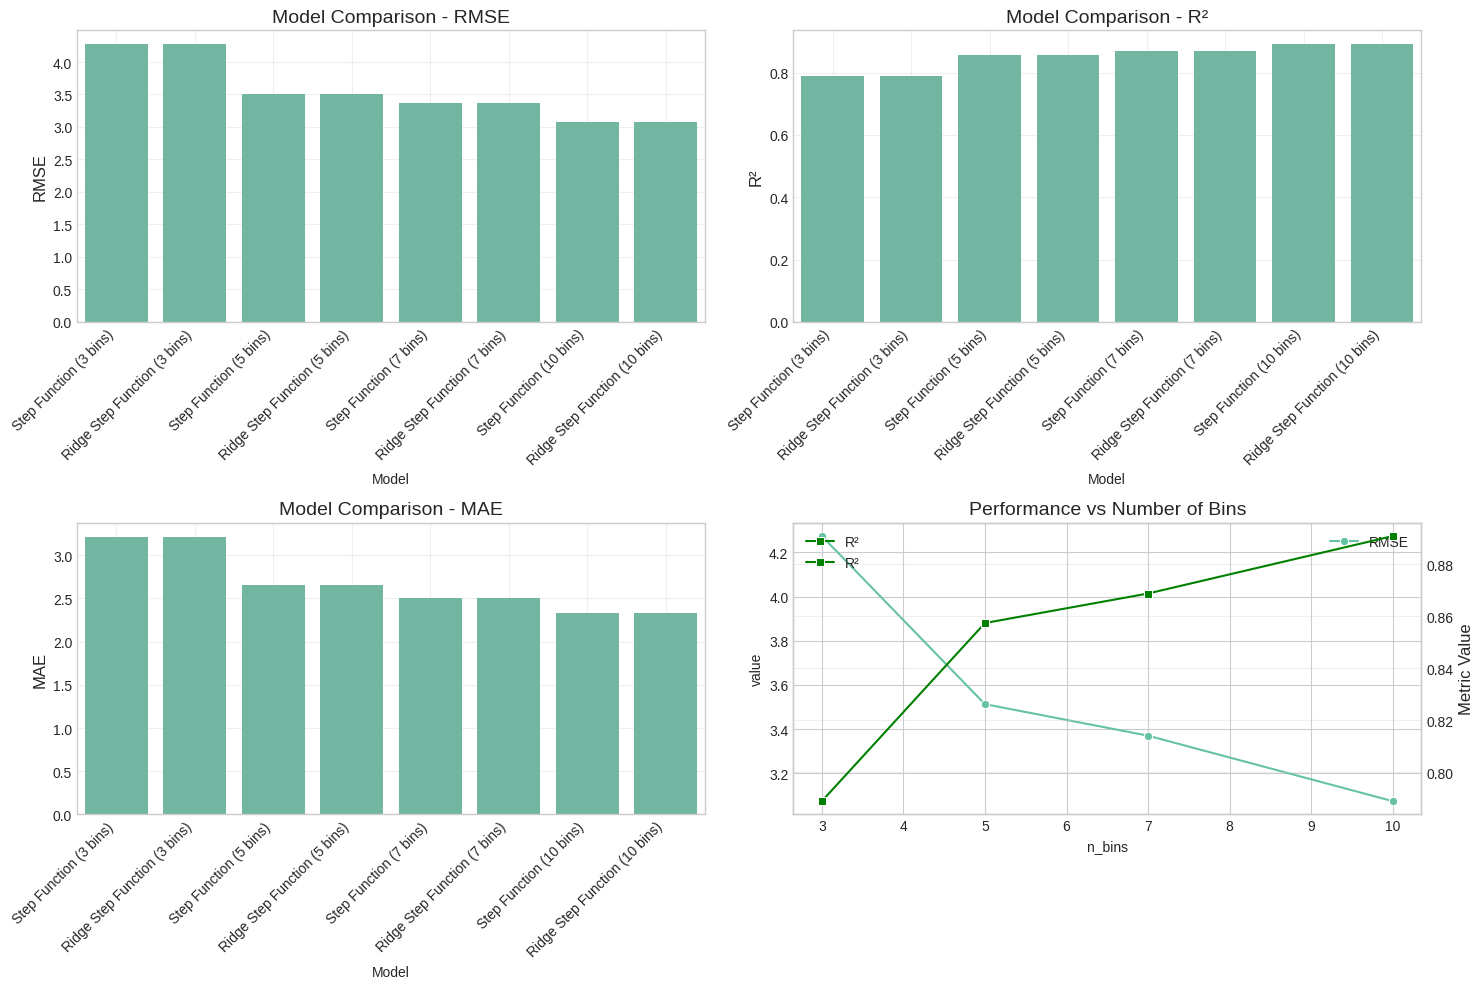


You can compare step function models with polynomial regression models
by examining both model's performance metrics and visualizations.

Performing cross-validation for the best step function model...
Cross-validation R² scores: [0.8907389  0.89457177 0.86465357 0.8879083  0.87253886]
Mean CV R²: 0.8821
Standard deviation of CV R²: 0.0115

Creating detailed visualizations for step functions...


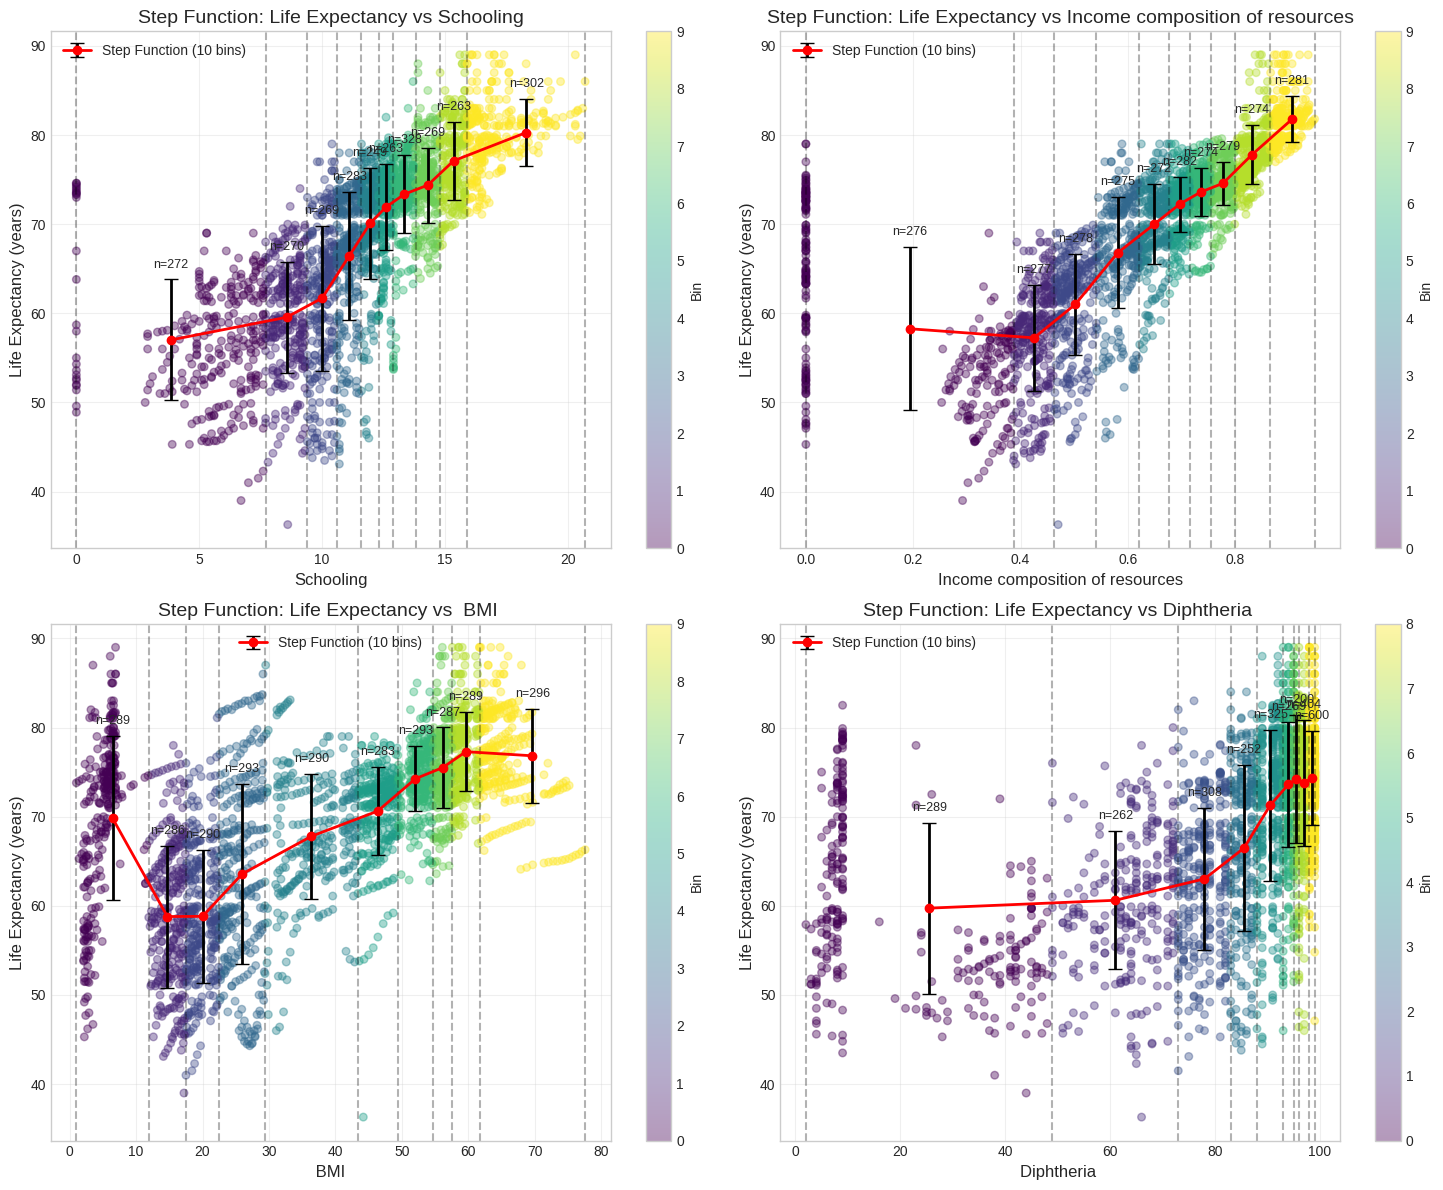


Step function modeling complete. Here's a summary:
1. Best step function model: Step Function (10 bins)
2. Performance metrics: RMSE = 3.0743, R² = 0.8907, MAE = 2.3371
3. Cross-validation R² score: 0.8821 ± 0.0115

The step function approach allows identifying critical thresholds in features that affect life expectancy.


In [ ]:
# Set the style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# Define a custom transformer for step functions
class StepFunctionTransformer(BaseEstimator, TransformerMixin):
    """
    Create step functions for numerical features by binning them into quantiles
    and creating dummy variables for each bin.
    """
    def __init__(self, n_bins=4, strategy='quantile'):
        self.n_bins = n_bins
        self.strategy = strategy
        self.discretizers = {}
        self.feature_names_in_ = None

    def fit(self, X, y=None):
        # Check if X is a DataFrame or numpy array
        if hasattr(X, 'columns'):
            # It's a DataFrame
            self.feature_names_in_ = list(X.columns)
        else:
            # It's a numpy array, use positional indices as feature names
            self.feature_names_in_ = [f'feature_{i}' for i in range(X.shape[1])]

        # Create a discretizer for each column/feature
        for i, col in enumerate(self.feature_names_in_):
            discretizer = KBinsDiscretizer(
                n_bins=self.n_bins,
                encode='onehot-dense',
                strategy=self.strategy
            )

            # Extract the column data properly based on input type
            if hasattr(X, 'iloc'):
                # DataFrame
                values = X.iloc[:, i].values.reshape(-1, 1)
            else:
                # Numpy array
                values = X[:, i].reshape(-1, 1)

            discretizer.fit(values)
            self.discretizers[col] = discretizer

        return self

    def transform(self, X):
        # Create an empty array to store transformed features
        transformed_data = []

        # Transform each column
        for i, col in enumerate(self.feature_names_in_):
            if col in self.discretizers:
                # Extract the column data properly based on input type
                if hasattr(X, 'iloc'):
                    # DataFrame
                    values = X.iloc[:, i].values.reshape(-1, 1)
                else:
                    # Numpy array
                    values = X[:, i].reshape(-1, 1)

                # Transform to one-hot encoded bins
                binned = self.discretizers[col].transform(values)
                transformed_data.append(binned)

        # Concatenate all transformed features
        if transformed_data:
            return np.hstack(transformed_data)
        else:
            return np.array([])

    def get_feature_names_out(self, input_features=None):
        feature_names = []
        for col in self.feature_names_in_:
            for i in range(self.n_bins):
                feature_names.append(f"{col}_bin_{i}")
        return np.array(feature_names)

# 1. Load and preprocess the data
print("Loading and preprocessing data...")
data = pd.read_csv('Life Expectancy Data.csv')

# Display basic information
print(f"Dataset shape: {data.shape}")
print("\nFirst 5 rows:")
print(data.head())

# Information about data types
print("\nData types:")
print(data.dtypes)

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])

# Identify categorical and numerical columns
categorical_columns = ['Country', 'Status']
numerical_columns = [col for col in data.columns if col not in categorical_columns and col != 'Life expectancy ']

print(f"\nCategorical columns: {categorical_columns}")
print(f"Numerical columns: {len(numerical_columns)}")

# 2. Exploratory Data Analysis specifically for step functions
print("\nPerforming EDA for step functions...")

# Find top correlated features for step function analysis
numeric_cols = data.select_dtypes(include=[np.number]).columns
correlation = data[numeric_cols].corr()['Life expectancy '].sort_values(ascending=False)
top_corr = correlation.drop('Life expectancy ').head(6)

# Plot step functions for top correlating features
plt.figure(figsize=(20, 15))

for i, feature in enumerate(top_corr.index):
    plt.subplot(2, 3, i+1)

    # Create a temporary discretizer for visualization
    n_bins = 5  # Number of steps to show
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')

    # Filter out missing values
    valid_data = data.dropna(subset=[feature, 'Life expectancy '])

    # Get feature values and transform to bins
    X_feature = valid_data[feature].values.reshape(-1, 1)
    bins = discretizer.fit_transform(X_feature).flatten()

    # Calculate mean life expectancy for each bin
    bin_means = {}
    for bin_idx in range(n_bins):
        bin_mask = (bins == bin_idx)
        bin_means[bin_idx] = valid_data.loc[bin_mask, 'Life expectancy '].mean()

    # Plot original data points with color indicating the bin
    plt.scatter(valid_data[feature], valid_data['Life expectancy '],
                c=bins, cmap='viridis', alpha=0.5, s=30)

    # Plot step function using bin edges and means
    bin_edges = discretizer.bin_edges_[0]
    x_edges = np.append(bin_edges, np.max(X_feature))  # Add the rightmost edge

    # Create step function line
    x_steps = []
    y_steps = []

    for j in range(n_bins):
        # Left edge of step
        x_steps.append(bin_edges[j])
        y_steps.append(bin_means[j])

        # Right edge of step (same y-value)
        x_steps.append(bin_edges[j+1] if j < n_bins-1 else x_edges[-1])
        y_steps.append(bin_means[j])

    # Plot step function
    plt.plot(x_steps, y_steps, 'r-', linewidth=2, label=f'Step Function ({n_bins} bins)')

    # Add bin edge markers
    for edge in bin_edges:
        plt.axvline(x=edge, color='black', linestyle='--', alpha=0.3)

    plt.title(f'Step Function: Life Expectancy vs {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Life Expectancy (years)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()

# 3. Prepare data for modeling
print("\nPreparing data for modeling...")

# Drop rows where target variable is missing
data = data.dropna(subset=['Life expectancy '])

# Select features and target
X = data.drop(['Life expectancy '], axis=1)
y = data['Life expectancy ']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Create preprocessing pipeline with proper handling of features
print("\nCreating preprocessing pipeline...")

# For categorical columns, we need to handle them separately
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# For numerical columns, use standard preprocessing
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, ['Status'])  # Only include 'Status', not 'Country'
    ],
    remainder='drop'  # Drop Country column
)

# 5. Build step function models with different bin numbers
print("\nBuilding step function models...")

# Function to evaluate model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print metrics
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")

    return model, test_rmse, test_r2, y_test, y_test_pred

# Apply preprocessing to get the transformed data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Get feature names after preprocessing
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names_out = preprocessor.get_feature_names_out()
else:
    # For older scikit-learn versions
    feature_names_out = [f'feature_{i}' for i in range(X_train_preprocessed.shape[1])]

# Number of bins to try
bin_numbers = [3, 5, 7, 10]
results = []

for n_bins in bin_numbers:
    print(f"\nStep Function with {n_bins} bins:")

    # Create a step function transformer
    step_transformer = StepFunctionTransformer(n_bins=n_bins)

    # Apply the step function transformation
    X_train_step = step_transformer.fit_transform(X_train_preprocessed)
    X_test_step = step_transformer.transform(X_test_preprocessed)

    # Create and evaluate LinearRegression model
    linear_model = LinearRegression()
    print("\nLinear Regression with Step Functions:")
    linear_model.fit(X_train_step, y_train)

    # Make predictions
    y_train_pred = linear_model.predict(X_train_step)
    y_test_pred = linear_model.predict(X_test_step)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print metrics
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")

    # Store results
    results.append({
        'Model': f"Step Function ({n_bins} bins)",
        'RMSE': test_rmse,
        'R²': test_r2,
        'MAE': test_mae,
        'n_bins': n_bins,
        'y_true': y_test,
        'y_pred': y_test_pred
    })

    # Try Ridge Regression for regularization with step functions
    ridge_model = Ridge(alpha=1.0)
    print(f"\nRidge Regression with Step Functions ({n_bins} bins):")
    ridge_model.fit(X_train_step, y_train)

    # Make predictions
    y_train_pred = ridge_model.predict(X_train_step)
    y_test_pred = ridge_model.predict(X_test_step)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print metrics
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")

    results.append({
        'Model': f"Ridge Step Function ({n_bins} bins)",
        'RMSE': test_rmse,
        'R²': test_r2,
        'MAE': test_mae,
        'n_bins': n_bins,
        'y_true': y_test,
        'y_pred': y_test_pred
    })

# 6. Visualize results and model performance
print("\nVisualizing model performance...")

# Find best model
best_model = min(results, key=lambda x: x['RMSE'])
print(f"\nBest Step Function Model: {best_model['Model']} (RMSE: {best_model['RMSE']:.4f}, R²: {best_model['R²']:.4f})")

# Plot actual vs. predicted values for best model
plt.figure(figsize=(10, 6))
plt.scatter(best_model['y_true'], best_model['y_pred'], alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Life Expectancy', fontsize=12)
plt.ylabel('Predicted Life Expectancy', fontsize=12)
plt.title(f'Actual vs. Predicted Life Expectancy\n{best_model["Model"]}', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

# Plot model comparison
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
models_df = pd.DataFrame([(r['Model'], r['RMSE']) for r in results], columns=['Model', 'RMSE'])
sns.barplot(x='Model', y='RMSE', data=models_df)
plt.title('Model Comparison - RMSE', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('RMSE', fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
models_df = pd.DataFrame([(r['Model'], r['R²']) for r in results], columns=['Model', 'R²'])
sns.barplot(x='Model', y='R²', data=models_df)
plt.title('Model Comparison - R²', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('R²', fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
models_df = pd.DataFrame([(r['Model'], r['MAE']) for r in results], columns=['Model', 'MAE'])
sns.barplot(x='Model', y='MAE', data=models_df)
plt.title('Model Comparison - MAE', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('MAE', fontsize=12)
plt.grid(True, alpha=0.3)

# Plot bin number vs performance for step functions
plt.subplot(2, 2, 4)
bin_performance = pd.DataFrame([
    (r['n_bins'], r['RMSE'], 'RMSE') for r in results if 'Ridge' not in r['Model']
] + [
    (r['n_bins'], r['R²'], 'R²') for r in results if 'Ridge' not in r['Model']
], columns=['n_bins', 'value', 'metric'])

sns.lineplot(data=bin_performance[bin_performance['metric'] == 'RMSE'],
             x='n_bins', y='value', marker='o', label='RMSE')

ax2 = plt.twinx()
sns.lineplot(data=bin_performance[bin_performance['metric'] == 'R²'],
             x='n_bins', y='value', marker='s', color='green', ax=ax2, label='R²')

plt.title('Performance vs Number of Bins', fontsize=14)
plt.xlabel('Number of Bins', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.grid(True, alpha=0.3)
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

plt.tight_layout()
plt.show()

# 7. Compare with other non-linear models
print("\nYou can compare step function models with polynomial regression models")
print("by examining both model's performance metrics and visualizations.")

# 8. Cross-validation for the best model to ensure robustness
print("\nPerforming cross-validation for the best step function model...")

best_n_bins = best_model['n_bins']
is_ridge = 'Ridge' in best_model['Model']

# Perform 5-fold cross-validation manually to handle the step function transformer
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_idx, val_idx in cv.split(X):
    # Split data
    X_cv_train, X_cv_val = X.iloc[train_idx], X.iloc[val_idx]
    y_cv_train, y_cv_val = y.iloc[train_idx], y.iloc[val_idx]

    # Preprocess
    X_cv_train_prep = preprocessor.fit_transform(X_cv_train)
    X_cv_val_prep = preprocessor.transform(X_cv_val)

    # Apply step function
    step_transformer = StepFunctionTransformer(n_bins=best_n_bins)
    X_cv_train_step = step_transformer.fit_transform(X_cv_train_prep)
    X_cv_val_step = step_transformer.transform(X_cv_val_prep)

    # Fit model
    if is_ridge:
        model = Ridge(alpha=1.0)
    else:
        model = LinearRegression()

    model.fit(X_cv_train_step, y_cv_train)

    # Predict and score
    y_cv_val_pred = model.predict(X_cv_val_step)
    cv_scores.append(r2_score(y_cv_val, y_cv_val_pred))

cv_scores = np.array(cv_scores)
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f}")
print(f"Standard deviation of CV R²: {cv_scores.std():.4f}")

# 9. Create a combined visualization for top features with step functions
print("\nCreating detailed visualizations for step functions...")

# Get the best number of bins
best_n_bins = best_model['n_bins']

# Create visualization for the 4 most important features
top_4_features = list(top_corr.index[:4])

plt.figure(figsize=(15, 12))

for i, feature in enumerate(top_4_features):
    plt.subplot(2, 2, i+1)

    # Create a discretizer for the chosen number of bins
    discretizer = KBinsDiscretizer(n_bins=best_n_bins, encode='ordinal', strategy='quantile')

    # Filter out missing values
    valid_data = data.dropna(subset=[feature, 'Life expectancy '])

    # Get feature values and transform to bins
    X_feature = valid_data[feature].values.reshape(-1, 1)
    bins = discretizer.fit_transform(X_feature).flatten()

    # Get bin edges
    bin_edges = discretizer.bin_edges_[0]

    # Calculate mean and std of life expectancy for each bin
    bin_stats = {}
    for bin_idx in range(best_n_bins):
        bin_mask = (bins == bin_idx)
        bin_values = valid_data.loc[bin_mask, 'Life expectancy ']
        bin_stats[bin_idx] = {
            'mean': bin_values.mean(),
            'std': bin_values.std(),
            'count': bin_values.count()
        }

    # Plot original data with step function overlay
    scatter = plt.scatter(valid_data[feature], valid_data['Life expectancy '],
                         c=bins, cmap='viridis', alpha=0.4, s=30)

    # Create step function with error bars
    x_points = []
    y_points = []
    y_std = []

    for j in range(best_n_bins):
        # Bin center (for plotting)
        if j < best_n_bins - 1:
            bin_center = (bin_edges[j] + bin_edges[j+1]) / 2
        else:
            bin_center = (bin_edges[j] + np.max(X_feature)) / 2

        x_points.append(bin_center)
        y_points.append(bin_stats[j]['mean'])
        y_std.append(bin_stats[j]['std'])

    # Plot step function with error bars
    plt.errorbar(x_points, y_points, yerr=y_std, fmt='ro-', linewidth=2,
                 ecolor='black', capsize=5, label=f'Step Function ({best_n_bins} bins)')

    # Add bin edge markers
    for edge in bin_edges:
        plt.axvline(x=edge, color='black', linestyle='--', alpha=0.3)

    # Add annotations with bin statistics
    for j in range(best_n_bins):
        if j < best_n_bins - 1:
            bin_center = (bin_edges[j] + bin_edges[j+1]) / 2
        else:
            bin_center = (bin_edges[j] + np.max(X_feature)) / 2

        plt.annotate(f"n={bin_stats[j]['count']}",
                    xy=(bin_center, bin_stats[j]['mean'] + bin_stats[j]['std'] + 1),
                    ha='center', va='bottom', fontsize=9)

    plt.title(f'Step Function: Life Expectancy vs {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Life Expectancy (years)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Add colorbar to indicate bins
    cbar = plt.colorbar(scatter)
    cbar.set_label('Bin', fontsize=10)

plt.tight_layout()
plt.show()

# 10. Print conclusion
print("\nStep function modeling complete. Here's a summary:")
print(f"1. Best step function model: {best_model['Model']}")
print(f"2. Performance metrics: RMSE = {best_model['RMSE']:.4f}, R² = {best_model['R²']:.4f}, MAE = {best_model['MAE']:.4f}")
print(f"3. Cross-validation R² score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print("\nThe step function approach allows identifying critical thresholds in features that affect life expectancy.")

Loading and preprocessing data...
Dataset shape: (2938, 22)

First 5 rows:
       Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   

   Polio  T

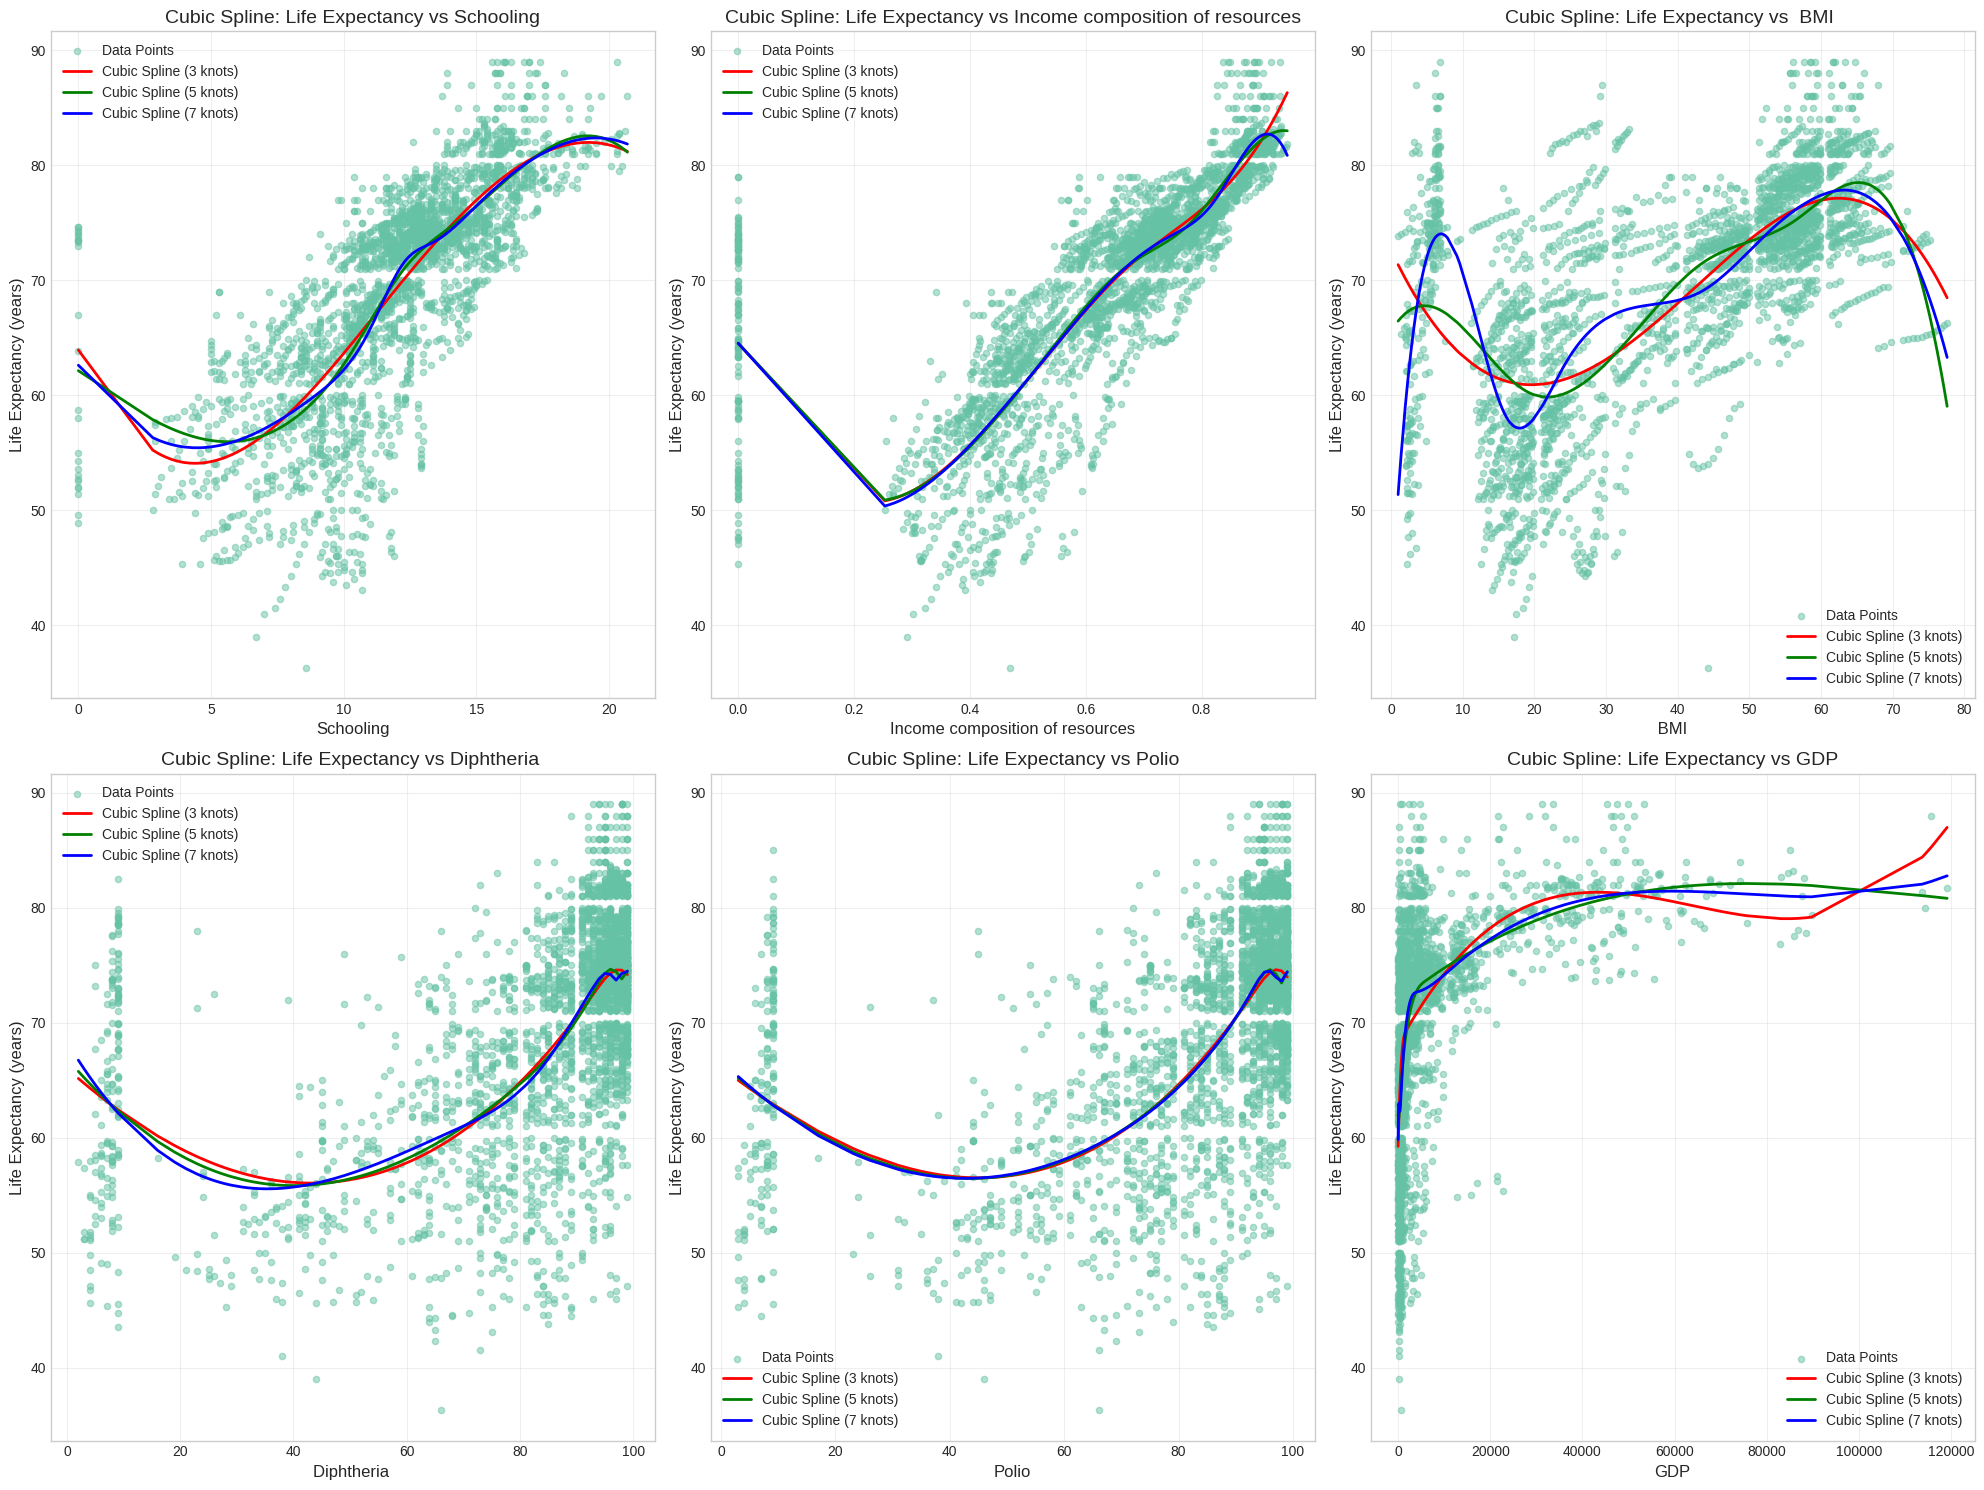


Preparing data for modeling...

Creating preprocessing pipeline...

Building spline regression models...

Cubic Spline with 3 knots:

Linear Regression with Cubic Splines:
Train RMSE: 3.0824
Test RMSE: 3.2240
Train MAE: 2.2636
Test MAE: 2.3396
Train R²: 0.8964
Test R²: 0.8798

Ridge Regression with Cubic Splines (3 knots):
Train RMSE: 3.1789
Test RMSE: 3.2743
Train MAE: 2.3478
Test MAE: 2.3687
Train R²: 0.8898
Test R²: 0.8761

Cubic Spline with 5 knots:

Linear Regression with Cubic Splines:
Train RMSE: 2.7839
Test RMSE: 2.9837
Train MAE: 2.0439
Test MAE: 2.1921
Train R²: 0.9155
Test R²: 0.8971

Ridge Regression with Cubic Splines (5 knots):
Train RMSE: 2.8745
Test RMSE: 2.9840
Train MAE: 2.1171
Test MAE: 2.1908
Train R²: 0.9099
Test R²: 0.8971

Cubic Spline with 7 knots:

Linear Regression with Cubic Splines:
Train RMSE: 2.6914
Test RMSE: 2.9592
Train MAE: 1.9769
Test MAE: 2.1334
Train R²: 0.9210
Test R²: 0.8988

Ridge Regression with Cubic Splines (7 knots):
Train RMSE: 2.7807
Test 

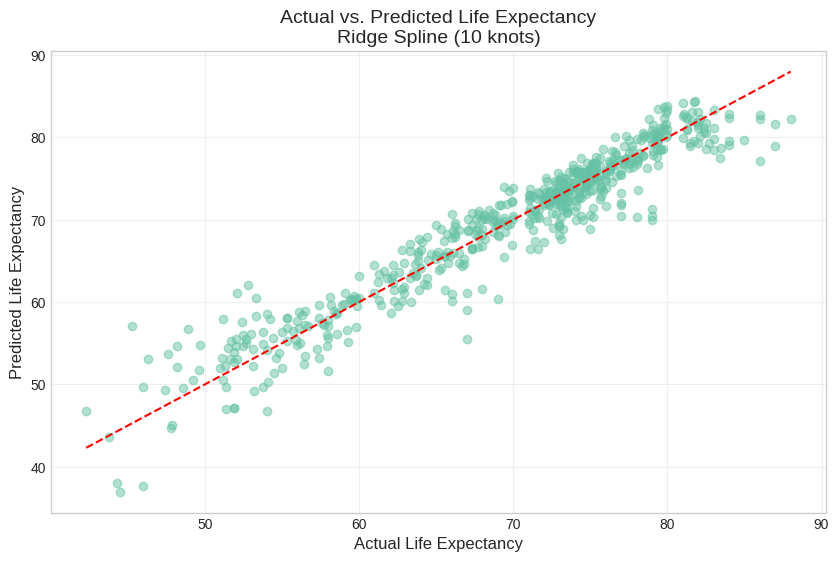

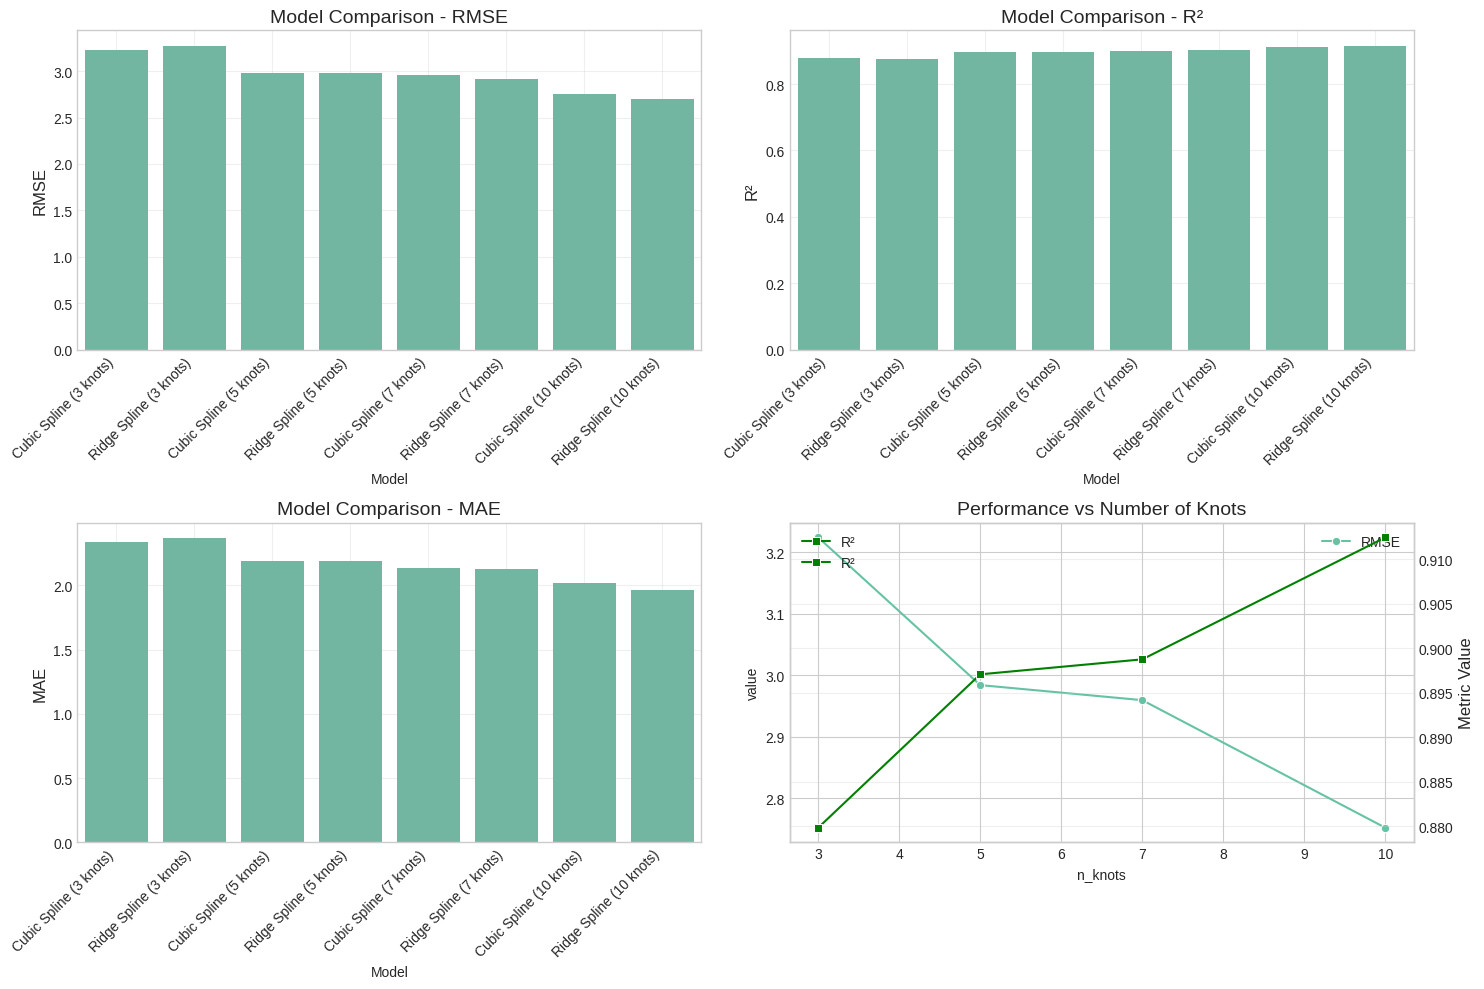


You can compare spline models with polynomial regression and step function models
by examining each model's performance metrics and visualizations.

Performing cross-validation for the best spline model...
Cross-validation R² scores: [0.91590612 0.9195131  0.89897242 0.92371371 0.91119636]
Mean CV R²: 0.9139
Standard deviation of CV R²: 0.0085

Visualizing individual feature spline effects:

Analyzing feature: Schooling


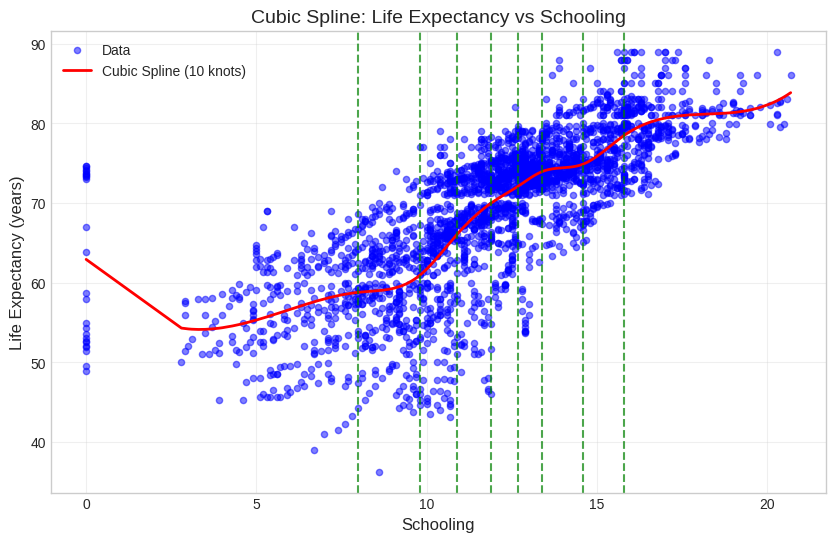

Effect of Schooling on Life Expectancy: 29.71 years
Range of Schooling: 0.00 to 20.70

Analyzing feature: Income composition of resources


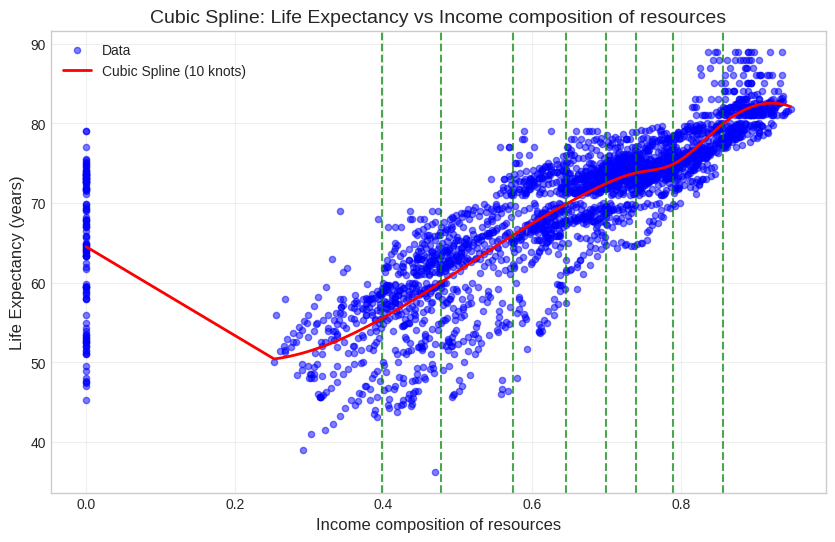

Effect of Income composition of resources on Life Expectancy: 32.10 years
Range of Income composition of resources: 0.00 to 0.95

Analyzing feature:  BMI 


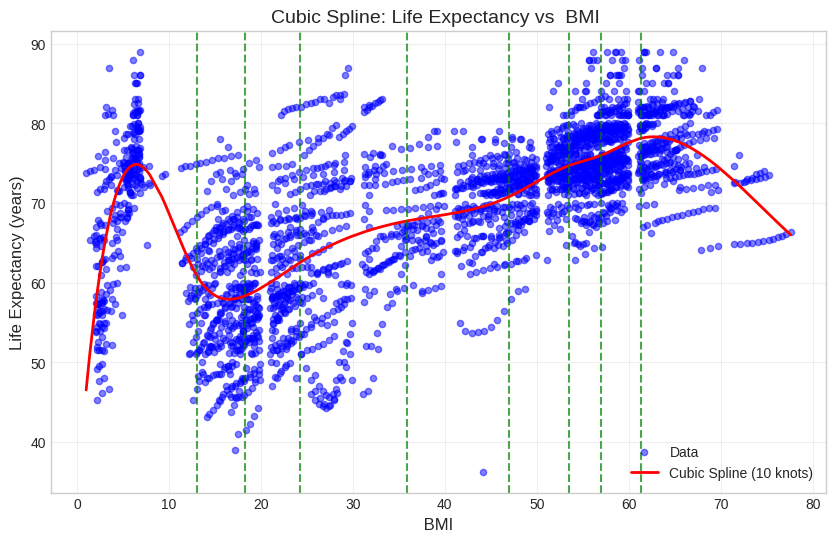

Effect of  BMI  on Life Expectancy: 31.76 years
Range of  BMI : 1.00 to 77.60

Spline regression modeling complete. Here's a summary:
1. Best spline model: Ridge Spline (10 knots)
2. Performance metrics: RMSE = 2.6970, R² = 0.9159, MAE = 1.9645
3. Cross-validation R² score: 0.9139 ± 0.0085

The spline regression approach allows for smooth non-linear modeling of relationships
between features and life expectancy, with continuous derivatives at the knots.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
from scipy import interpolate
from patsy import dmatrix
import statsmodels.api as sm
warnings.filterwarnings('ignore')

# Set the style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# Define a custom transformer for natural cubic splines
class NaturalCubicSplineTransformer(BaseEstimator, TransformerMixin):
    """
    Create natural cubic spline features.
    """
    def __init__(self, n_knots=5, knot_positions='quantile'):
        self.n_knots = n_knots
        self.knot_positions = knot_positions
        self.bsplines = {}
        self.feature_names_in_ = None

    def fit(self, X, y=None):
        # Check if X is a DataFrame or numpy array
        if hasattr(X, 'columns'):
            # It's a DataFrame
            self.feature_names_in_ = list(X.columns)
        else:
            # It's a numpy array, use positional indices as feature names
            self.feature_names_in_ = [f'feature_{i}' for i in range(X.shape[1])]

        # Create a spline for each column/feature
        for i, col in enumerate(self.feature_names_in_):
            # Extract the column data
            if hasattr(X, 'iloc'):
                # DataFrame
                x = X.iloc[:, i].values
            else:
                # Numpy array
                x = X[:, i]

            # Skip if all values are the same (can't create knots)
            if np.all(x == x[0]):
                continue

            # Determine knot positions
            if self.knot_positions == 'quantile':
                knots = np.percentile(x, np.linspace(0, 100, self.n_knots)[1:-1])
            else:
                # Uniform spacing
                knots = np.linspace(
                    np.min(x), np.max(x), self.n_knots)[1:-1]

            # Store the knots for this feature
            self.bsplines[col] = knots

        return self

    def transform(self, X):
        # Create an empty list to store spline features
        transformed_features = []

        # Transform each column
        for i, col in enumerate(self.feature_names_in_):
            if col in self.bsplines:
                # Extract the column data
                if hasattr(X, 'iloc'):
                    # DataFrame
                    x = X.iloc[:, i].values
                else:
                    # Numpy array
                    x = X[:, i]

                # Create spline features using patsy's dmatrix
                knots = self.bsplines[col]
                spline_features = dmatrix(
                    f"bs(x, knots={list(knots)}, degree=3, include_intercept=False)",
                    {"x": x},
                    return_type='dataframe'
                ).values

                transformed_features.append(spline_features)

            else:
                # For columns without splines, just use the original values
                if hasattr(X, 'iloc'):
                    x = X.iloc[:, i].values.reshape(-1, 1)
                else:
                    x = X[:, i].reshape(-1, 1)
                transformed_features.append(x)

        # Concatenate all transformed features
        if transformed_features:
            return np.hstack(transformed_features)
        else:
            return X

    def get_feature_names_out(self, input_features=None):
        feature_names = []
        for col in self.feature_names_in_:
            if col in self.bsplines:
                for i in range(len(self.bsplines[col]) + 3):  # +3 for cubic splines
                    feature_names.append(f"{col}_spline_{i}")
            else:
                feature_names.append(col)
        return np.array(feature_names)

# 1. Load and preprocess the data
print("Loading and preprocessing data...")
data = pd.read_csv('Life Expectancy Data.csv')

# Display basic information
print(f"Dataset shape: {data.shape}")
print("\nFirst 5 rows:")
print(data.head())

# Information about data types
print("\nData types:")
print(data.dtypes)

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])

# Identify categorical and numerical columns
categorical_columns = ['Country', 'Status']
numerical_columns = [col for col in data.columns if col not in categorical_columns and col != 'Life expectancy ']

print(f"\nCategorical columns: {categorical_columns}")
print(f"Numerical columns: {len(numerical_columns)}")

# 2. Exploratory Data Analysis specifically for splines
print("\nPerforming EDA for spline regression...")

# Find top correlated features for spline analysis
numeric_cols = data.select_dtypes(include=[np.number]).columns
correlation = data[numeric_cols].corr()['Life expectancy '].sort_values(ascending=False)
top_corr = correlation.drop('Life expectancy ').head(6)

# Plot splines for top correlating features
plt.figure(figsize=(20, 15))

for i, feature in enumerate(top_corr.index):
    plt.subplot(2, 3, i+1)

    # Filter out missing values
    valid_data = data.dropna(subset=[feature, 'Life expectancy '])

    # Sort data by feature value for smooth curves
    sorted_idx = np.argsort(valid_data[feature].values)
    x_sorted = valid_data[feature].values[sorted_idx]
    y_sorted = valid_data['Life expectancy '].values[sorted_idx]

    # Plot original data points
    plt.scatter(x_sorted, y_sorted, alpha=0.5, s=20, label='Data Points')

    # Fit and plot splines with different degrees of freedom (number of knots)
    colors = ['red', 'green', 'blue']
    knot_counts = [3, 5, 7]

    for j, (n_knots, color) in enumerate(zip(knot_counts, colors)):
        # Skip if too few data points
        if len(x_sorted) <= n_knots:
            continue

        # Define knots at quantiles of x
        knots = np.percentile(x_sorted, np.linspace(0, 100, n_knots)[1:-1])

        # Generate spline basis
        spline_basis = dmatrix(
            f"bs(x, knots={list(knots)}, degree=3, include_intercept=True)",
            {"x": x_sorted},
            return_type='dataframe'
        )

        # Fit linear regression model on the spline basis
        model = sm.OLS(y_sorted, spline_basis).fit()

        # Generate predictions
        y_pred = model.predict(spline_basis)

        # Plot spline fit
        plt.plot(x_sorted, y_pred, color=color, linestyle='-', linewidth=2,
                 label=f'Cubic Spline ({n_knots} knots)')

    plt.title(f'Cubic Spline: Life Expectancy vs {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Life Expectancy (years)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()

# 3. Prepare data for modeling
print("\nPreparing data for modeling...")

# Drop rows where target variable is missing
data = data.dropna(subset=['Life expectancy '])

# Select features and target
X = data.drop(['Life expectancy '], axis=1)
y = data['Life expectancy ']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Create preprocessing pipeline with proper handling of features
print("\nCreating preprocessing pipeline...")

# For categorical columns, handle them separately
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# For numerical columns, use standard preprocessing
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, ['Status'])  # Only include 'Status', not 'Country'
    ],
    remainder='drop'  # Drop Country column
)

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Get feature names after preprocessing if available
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names_out = preprocessor.get_feature_names_out()
else:
    feature_names_out = [f'feature_{i}' for i in range(X_train_preprocessed.shape[1])]

# 5. Build spline regression models with different numbers of knots
print("\nBuilding spline regression models...")

# Function to evaluate model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print metrics
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")

    return model, test_rmse, test_r2, y_test, y_test_pred

# Number of knots to try
knot_numbers = [3, 5, 7, 10]
results = []

for n_knots in knot_numbers:
    print(f"\nCubic Spline with {n_knots} knots:")

    # Create a spline transformer
    spline_transformer = NaturalCubicSplineTransformer(n_knots=n_knots)

    # Apply the spline transformation
    X_train_spline = spline_transformer.fit_transform(X_train_preprocessed)
    X_test_spline = spline_transformer.transform(X_test_preprocessed)

    # Create and evaluate LinearRegression model
    linear_model = LinearRegression()
    print("\nLinear Regression with Cubic Splines:")
    linear_model.fit(X_train_spline, y_train)

    # Make predictions
    y_train_pred = linear_model.predict(X_train_spline)
    y_test_pred = linear_model.predict(X_test_spline)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print metrics
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")

    # Store results
    results.append({
        'Model': f"Cubic Spline ({n_knots} knots)",
        'RMSE': test_rmse,
        'R²': test_r2,
        'MAE': test_mae,
        'n_knots': n_knots,
        'y_true': y_test,
        'y_pred': y_test_pred
    })

    # Try Ridge Regression for regularization with splines
    ridge_model = Ridge(alpha=1.0)
    print(f"\nRidge Regression with Cubic Splines ({n_knots} knots):")
    ridge_model.fit(X_train_spline, y_train)

    # Make predictions
    y_train_pred = ridge_model.predict(X_train_spline)
    y_test_pred = ridge_model.predict(X_test_spline)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print metrics
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")

    results.append({
        'Model': f"Ridge Spline ({n_knots} knots)",
        'RMSE': test_rmse,
        'R²': test_r2,
        'MAE': test_mae,
        'n_knots': n_knots,
        'y_true': y_test,
        'y_pred': y_test_pred
    })

# 6. Visualize results and model performance
print("\nVisualizing model performance...")

# Find best model
best_model = min(results, key=lambda x: x['RMSE'])
print(f"\nBest Spline Model: {best_model['Model']} (RMSE: {best_model['RMSE']:.4f}, R²: {best_model['R²']:.4f})")

# Plot actual vs. predicted values for best model
plt.figure(figsize=(10, 6))
plt.scatter(best_model['y_true'], best_model['y_pred'], alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Life Expectancy', fontsize=12)
plt.ylabel('Predicted Life Expectancy', fontsize=12)
plt.title(f'Actual vs. Predicted Life Expectancy\n{best_model["Model"]}', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

# Plot model comparison
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
models_df = pd.DataFrame([(r['Model'], r['RMSE']) for r in results], columns=['Model', 'RMSE'])
sns.barplot(x='Model', y='RMSE', data=models_df)
plt.title('Model Comparison - RMSE', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('RMSE', fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
models_df = pd.DataFrame([(r['Model'], r['R²']) for r in results], columns=['Model', 'R²'])
sns.barplot(x='Model', y='R²', data=models_df)
plt.title('Model Comparison - R²', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('R²', fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
models_df = pd.DataFrame([(r['Model'], r['MAE']) for r in results], columns=['Model', 'MAE'])
sns.barplot(x='Model', y='MAE', data=models_df)
plt.title('Model Comparison - MAE', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('MAE', fontsize=12)
plt.grid(True, alpha=0.3)

# Plot knot number vs performance for spline models
plt.subplot(2, 2, 4)
knot_performance = pd.DataFrame([
    (r['n_knots'], r['RMSE'], 'RMSE') for r in results if 'Ridge' not in r['Model']
] + [
    (r['n_knots'], r['R²'], 'R²') for r in results if 'Ridge' not in r['Model']
], columns=['n_knots', 'value', 'metric'])

sns.lineplot(data=knot_performance[knot_performance['metric'] == 'RMSE'],
             x='n_knots', y='value', marker='o', label='RMSE')

ax2 = plt.twinx()
sns.lineplot(data=knot_performance[knot_performance['metric'] == 'R²'],
             x='n_knots', y='value', marker='s', color='green', ax=ax2, label='R²')

plt.title('Performance vs Number of Knots', fontsize=14)
plt.xlabel('Number of Knots', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.grid(True, alpha=0.3)
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

plt.tight_layout()
plt.show()

# 7. Compare with other non-linear models
print("\nYou can compare spline models with polynomial regression and step function models")
print("by examining each model's performance metrics and visualizations.")

# 8. Cross-validation for the best model to ensure robustness
print("\nPerforming cross-validation for the best spline model...")

best_n_knots = best_model['n_knots']
is_ridge = 'Ridge' in best_model['Model']

# Perform 5-fold cross-validation manually to handle the spline transformer
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_idx, val_idx in cv.split(X):
    # Split data
    X_cv_train, X_cv_val = X.iloc[train_idx], X.iloc[val_idx]
    y_cv_train, y_cv_val = y.iloc[train_idx], y.iloc[val_idx]

    # Preprocess
    X_cv_train_prep = preprocessor.fit_transform(X_cv_train)
    X_cv_val_prep = preprocessor.transform(X_cv_val)

    # Apply splines
    spline_transformer = NaturalCubicSplineTransformer(n_knots=best_n_knots)
    X_cv_train_spline = spline_transformer.fit_transform(X_cv_train_prep)
    X_cv_val_spline = spline_transformer.transform(X_cv_val_prep)

    # Fit model
    if is_ridge:
        model = Ridge(alpha=1.0)
    else:
        model = LinearRegression()

    model.fit(X_cv_train_spline, y_cv_train)

    # Predict and score
    y_cv_val_pred = model.predict(X_cv_val_spline)
    cv_scores.append(r2_score(y_cv_val, y_cv_val_pred))

cv_scores = np.array(cv_scores)
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f}")
print(f"Standard deviation of CV R²: {cv_scores.std():.4f}")

# 9. Create a function to visualize individual feature splines for interpretability
def plot_feature_spline(feature_name, n_knots=5):
    # Filter data
    valid_data = data.dropna(subset=[feature_name, 'Life expectancy '])

    # Sort by feature value
    sorted_idx = np.argsort(valid_data[feature_name].values)
    x_sorted = valid_data[feature_name].values[sorted_idx]
    y_sorted = valid_data['Life expectancy '].values[sorted_idx]

    # Define knots at quantiles
    knots = np.percentile(x_sorted, np.linspace(0, 100, n_knots)[1:-1])

    # Generate spline basis
    spline_basis = dmatrix(
        f"bs(x, knots={list(knots)}, degree=3, include_intercept=True)",
        {"x": x_sorted},
        return_type='dataframe'
    )

    # Fit model
    model = sm.OLS(y_sorted, spline_basis).fit()

    # Generate predictions
    y_pred = model.predict(spline_basis)

    # Plot data and spline
    plt.figure(figsize=(10, 6))
    plt.scatter(x_sorted, y_sorted, alpha=0.5, s=20, color='blue', label='Data')
    plt.plot(x_sorted, y_pred, color='red', linewidth=2, label=f'Cubic Spline ({n_knots} knots)')

    # Add knot locations
    for knot in knots:
        plt.axvline(x=knot, color='green', linestyle='--', alpha=0.7)

    plt.title(f'Cubic Spline: Life Expectancy vs {feature_name}', fontsize=14)
    plt.xlabel(feature_name, fontsize=12)
    plt.ylabel('Life Expectancy (years)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # Return the effect
    mean_y = np.mean(y_sorted)
    effect_size = max(y_pred) - min(y_pred)
    print(f"Effect of {feature_name} on Life Expectancy: {effect_size:.2f} years")
    print(f"Range of {feature_name}: {min(x_sorted):.2f} to {max(x_sorted):.2f}")

    return effect_size

# Visualize the spline effects for the top 3 features
print("\nVisualizing individual feature spline effects:")
for feature in top_corr.index[:3]:
    print(f"\nAnalyzing feature: {feature}")
    effect = plot_feature_spline(feature, best_n_knots)

# 10. Print conclusion
print("\nSpline regression modeling complete. Here's a summary:")
print(f"1. Best spline model: {best_model['Model']}")
print(f"2. Performance metrics: RMSE = {best_model['RMSE']:.4f}, R² = {best_model['R²']:.4f}, MAE = {best_model['MAE']:.4f}")
print(f"3. Cross-validation R² score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print("\nThe spline regression approach allows for smooth non-linear modeling of relationships")
print("between features and life expectancy, with continuous derivatives at the knots.")

Loading and preprocessing data...
Dataset shape: (2938, 22)

Missing values per column:
Life expectancy                     10
Adult Mortality                     10
Alcohol                            194
Hepatitis B                        553
 BMI                                34
Polio                               19
Total expenditure                  226
Diphtheria                          19
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

Preparing data for modeling...

Building local regression models...

Local Regression with k = 5:
Train RMSE: 0.7795
Test RMSE: 2.7560
Train MAE: 0.4183
Test MAE: 1.5824
Train R²: 0.9934
Test R²: 0.9122

Local Regression with k = 10:
Train RMSE: 1.2153
Test RMSE: 2.6639
Train MAE: 0.7671
Test MAE: 1.5980
Train R²: 0.9839
Test R²: 0.9180

Local Regres

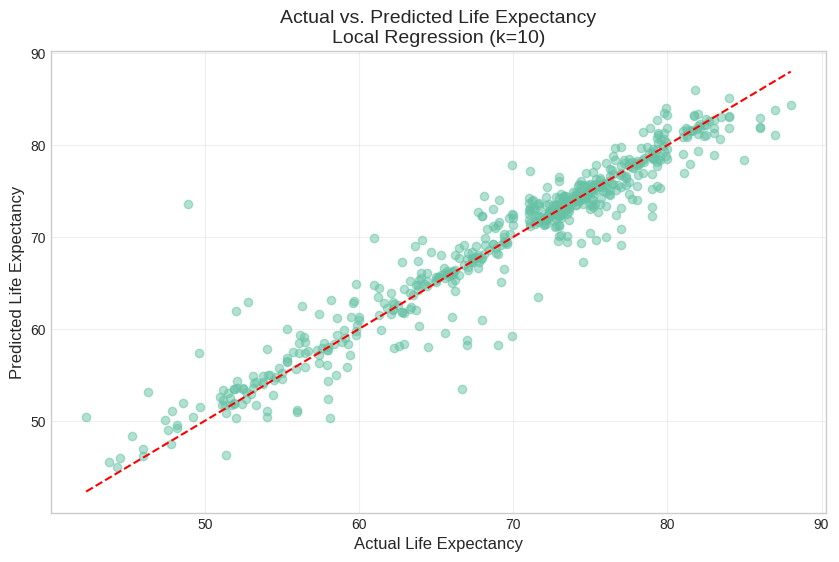

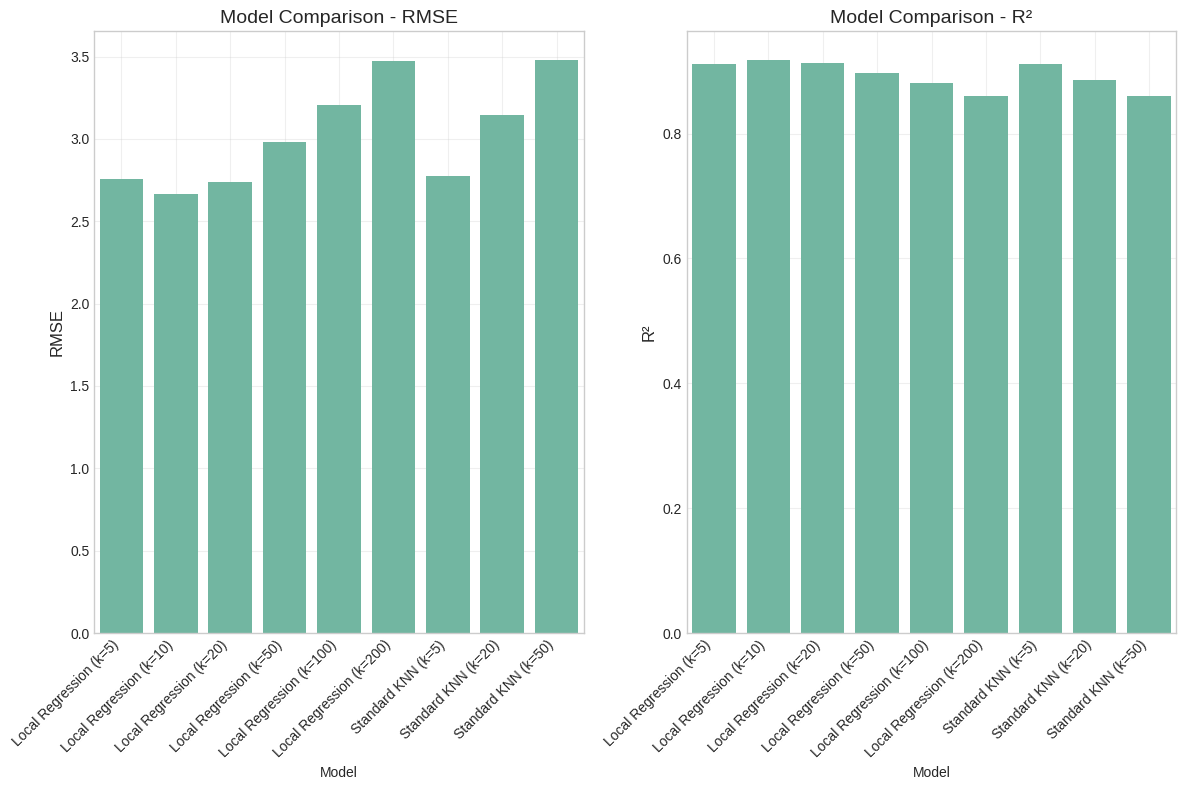

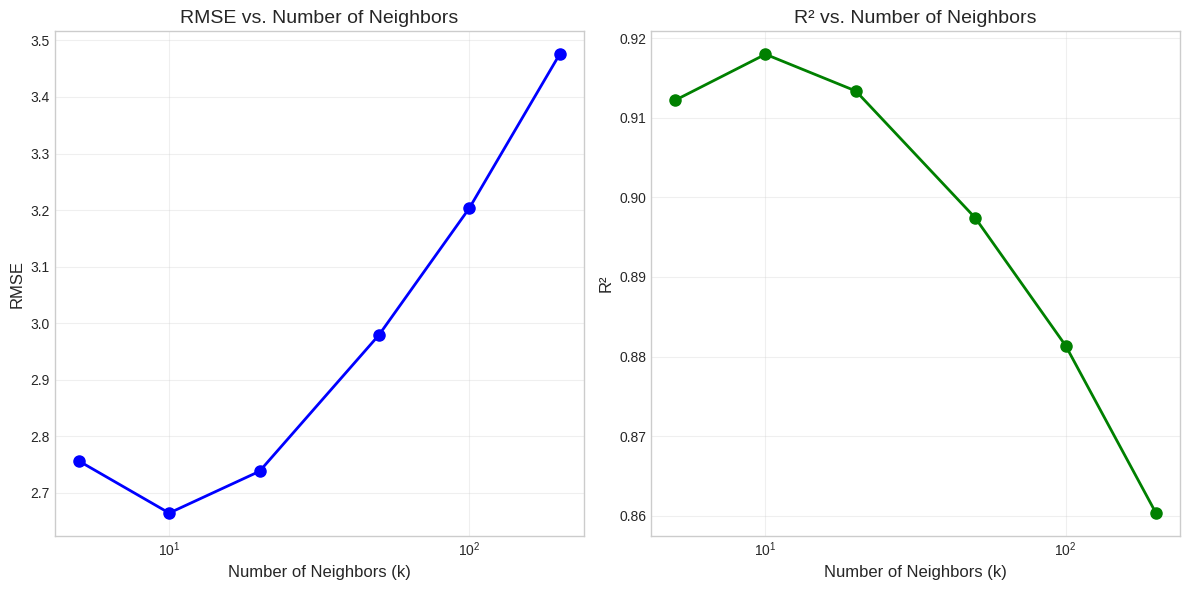


Analyzing feature importance...


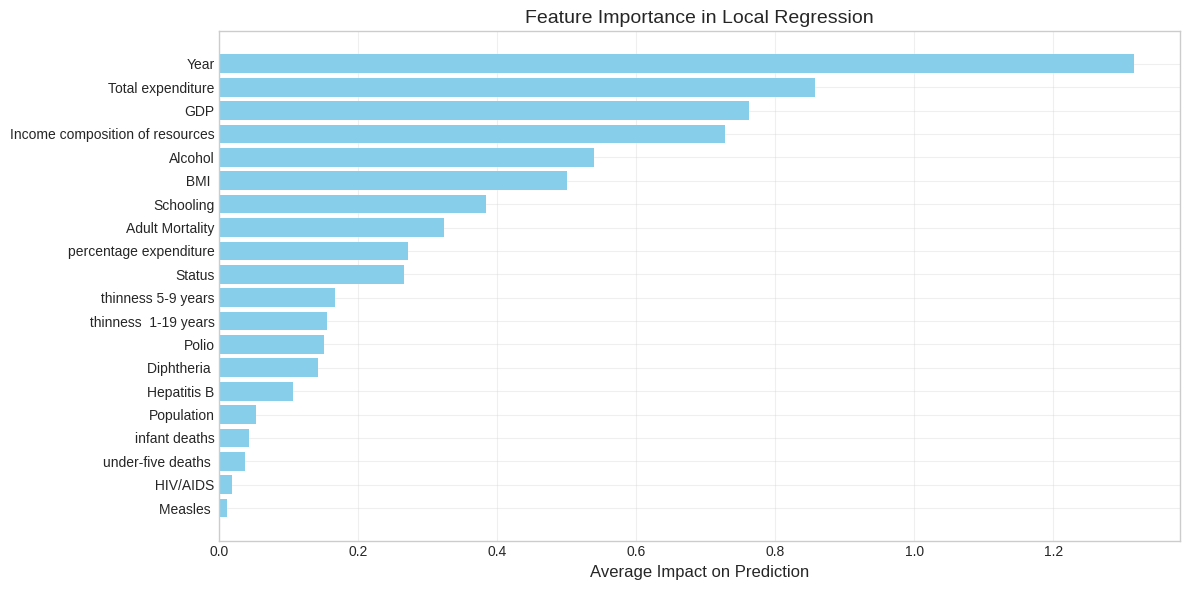


Local regression modeling complete. Here's a summary:
1. Best model: Local Regression (k=10)
2. Performance metrics: RMSE = 2.6639, R² = 0.9180, MAE = 1.5980

Local regression effectively captures non-linear patterns in the life expectancy data
without requiring specification of the functional form. It adapts to local patterns in the data.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.filterwarnings('ignore')

# Set the style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# 1. Load and preprocess the data
print("Loading and preprocessing data...")
data = pd.read_csv('Life Expectancy Data.csv')

# Display basic information
print(f"Dataset shape: {data.shape}")

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])

# 2. Prepare data for modeling
print("\nPreparing data for modeling...")

# Drop rows where target variable is missing
data = data.dropna(subset=['Life expectancy '])

# Convert to numpy arrays for processing
X_data = data.drop(['Life expectancy ', 'Country'], axis=1).copy()
y_data = data['Life expectancy '].values

# Convert categorical variable to numeric
X_data['Status'] = X_data['Status'].map({'Developing': 0, 'Developed': 1})

# Handle missing values in features with median imputation
for col in X_data.columns:
    if X_data[col].isnull().sum() > 0:
        median_value = X_data[col].median()
        X_data[col].fillna(median_value, inplace=True)

# Convert to numpy for further processing
X = X_data.values
y = y_data

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Define a custom KNN-based local regression model
class LocalRegressionKNN:
    def __init__(self, k=10, weighted=True):
        self.k = k
        self.weighted = weighted
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X):
        predictions = np.zeros(X.shape[0])

        for i in range(X.shape[0]):
            # Calculate distances to all training points
            distances = np.sqrt(np.sum((self.X_train - X[i])**2, axis=1))

            # Find indices of k nearest neighbors
            nearest_indices = np.argsort(distances)[:self.k]

            if self.weighted:
                # Calculate weights (inverse of distance)
                nearest_distances = distances[nearest_indices]
                # Avoid division by zero
                max_dist = np.max(nearest_distances)
                if max_dist > 0:
                    weights = (1 - (nearest_distances / max_dist)**3)**3
                else:
                    weights = np.ones_like(nearest_distances)

                # Weighted prediction
                predictions[i] = np.sum(weights * self.y_train[nearest_indices]) / np.sum(weights)
            else:
                # Simple average
                predictions[i] = np.mean(self.y_train[nearest_indices])

        return predictions

# 4. Build and evaluate local regression models
print("\nBuilding local regression models...")

# Try different k values
k_values = [5, 10, 20, 50, 100, 200]
results = []

for k in k_values:
    print(f"\nLocal Regression with k = {k}:")

    # Create model
    model = LocalRegressionKNN(k=k)

    # Train model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print metrics
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")

    # Store results
    results.append({
        'Model': f"Local Regression (k={k})",
        'RMSE': test_rmse,
        'R²': test_r2,
        'MAE': test_mae,
        'k': k,
        'y_true': y_test,
        'y_pred': y_test_pred
    })

# 5. Compare with standard KNN regressor
print("\nComparing with standard KNN regressor...")

for k in [5, 20, 50]:
    print(f"\nStandard KNN Regression with k = {k}:")

    # Create KNN model
    knn_model = KNeighborsRegressor(n_neighbors=k, weights='distance')

    # Train model
    knn_model.fit(X_train_scaled, y_train)

    # Make predictions
    y_train_pred = knn_model.predict(X_train_scaled)
    y_test_pred = knn_model.predict(X_test_scaled)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print metrics
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")

    # Store results
    results.append({
        'Model': f"Standard KNN (k={k})",
        'RMSE': test_rmse,
        'R²': test_r2,
        'MAE': test_mae,
        'k': k,
        'y_true': y_test,
        'y_pred': y_test_pred
    })

# 6. Visualize results and model performance
print("\nVisualizing model performance...")

# Find best model
best_model = min(results, key=lambda x: x['RMSE'])
print(f"\nBest Model: {best_model['Model']} (RMSE: {best_model['RMSE']:.4f}, R²: {best_model['R²']:.4f})")

# Plot actual vs. predicted values for best model
plt.figure(figsize=(10, 6))
plt.scatter(best_model['y_true'], best_model['y_pred'], alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Life Expectancy', fontsize=12)
plt.ylabel('Predicted Life Expectancy', fontsize=12)
plt.title(f'Actual vs. Predicted Life Expectancy\n{best_model["Model"]}', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

# Plot model comparison
plt.figure(figsize=(12, 8))

# RMSE comparison
plt.subplot(1, 2, 1)
models_df = pd.DataFrame([(r['Model'], r['RMSE']) for r in results], columns=['Model', 'RMSE'])
sns.barplot(x='Model', y='RMSE', data=models_df)
plt.title('Model Comparison - RMSE', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('RMSE', fontsize=12)
plt.grid(True, alpha=0.3)

# R² comparison
plt.subplot(1, 2, 2)
models_df = pd.DataFrame([(r['Model'], r['R²']) for r in results], columns=['Model', 'R²'])
sns.barplot(x='Model', y='R²', data=models_df)
plt.title('Model Comparison - R²', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('R²', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. Visualize relationship between k and performance
plt.figure(figsize=(12, 6))

# Extract local regression models
local_results = [r for r in results if 'Local Regression' in r['Model']]
k_values = [r['k'] for r in local_results]
rmse_values = [r['RMSE'] for r in local_results]
r2_values = [r['R²'] for r in local_results]

# Plot RMSE vs k
plt.subplot(1, 2, 1)
plt.plot(k_values, rmse_values, 'o-', color='blue', linewidth=2, markersize=8)
plt.xlabel('Number of Neighbors (k)', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('RMSE vs. Number of Neighbors', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xscale('log')  # Log scale for better visualization

# Plot R² vs k
plt.subplot(1, 2, 2)
plt.plot(k_values, r2_values, 'o-', color='green', linewidth=2, markersize=8)
plt.xlabel('Number of Neighbors (k)', fontsize=12)
plt.ylabel('R²', fontsize=12)
plt.title('R² vs. Number of Neighbors', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

# 8. Feature importance: examining how each feature affects predictions
print("\nAnalyzing feature importance...")

# Get column names for feature analysis
feature_names = X_data.columns.tolist()

# Select a few samples from the test set
n_samples = 5
sample_indices = np.random.choice(range(len(X_test)), n_samples, replace=False)
sample_X = X_test_scaled[sample_indices]
sample_y = y_test[sample_indices]

# Get the best k value from previous results
best_k = best_model['k']

# Initialize a model with the best k
local_model = LocalRegressionKNN(k=best_k)
local_model.fit(X_train_scaled, y_train)

# For each feature, calculate its impact on predictions by perturbing it
feature_impacts = []

for j in range(X_train.shape[1]):
    impacts = []

    for i in range(n_samples):
        # Create a perturbed version where this feature is set to its mean (zero after scaling)
        X_perturbed = sample_X[i].copy()
        original_value = X_perturbed[j]
        X_perturbed[j] = 0

        # Get predictions
        orig_pred = local_model.predict(sample_X[i].reshape(1, -1))[0]
        pert_pred = local_model.predict(X_perturbed.reshape(1, -1))[0]

        # Impact is the difference in predictions
        impact = abs(orig_pred - pert_pred)
        impacts.append(impact)

    # Average impact across samples
    avg_impact = np.mean(impacts)
    feature_impacts.append((feature_names[j], avg_impact))

# Sort features by impact
feature_impacts.sort(key=lambda x: x[1], reverse=True)

# Plot feature importance
plt.figure(figsize=(12, 6))
feature_names = [f[0] for f in feature_impacts]
feature_values = [f[1] for f in feature_impacts]

plt.barh(feature_names, feature_values, color='skyblue')
plt.xlabel('Average Impact on Prediction', fontsize=12)
plt.title('Feature Importance in Local Regression', fontsize=14)
plt.gca().invert_yaxis()  # Highest value at the top
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 9. Conclusion
print("\nLocal regression modeling complete. Here's a summary:")
print(f"1. Best model: {best_model['Model']}")
print(f"2. Performance metrics: RMSE = {best_model['RMSE']:.4f}, R² = {best_model['R²']:.4f}, MAE = {best_model['MAE']:.4f}")
print("\nLocal regression effectively captures non-linear patterns in the life expectancy data")
print("without requiring specification of the functional form. It adapts to local patterns in the data.")

Dataset shape: (1000, 8)

Sample of the dataset:
            GDP  HealthcareExpenditure  Education   Alcohol        BMI  \
0  12468.396949            1340.527847   8.420405  4.601717  31.692961   
1   7972.323651            3744.127377   8.429272  3.085887  24.248740   
2   7411.417922            2276.616094   7.707440  4.366010  24.796935   
3   7411.511472            2085.290742  12.628522  1.867502  28.581655   
4  23748.572061            2979.358525   7.871707  4.770063  41.990637   

    Smoking  Pollution  LifeExpectancy  
0  1.171256  18.234314            90.0  
1  1.831987  12.391533            90.0  
2  3.223952  34.391381            90.0  
3  2.983291  35.259502            90.0  
4  6.164934   9.389521            90.0  

Dataset summary statistics:
                GDP  HealthcareExpenditure    Education      Alcohol  \
count   1000.000000            1000.000000  1000.000000  1000.000000   
mean   10799.651331            3367.956342     9.917361     3.983042   
std     7014.28

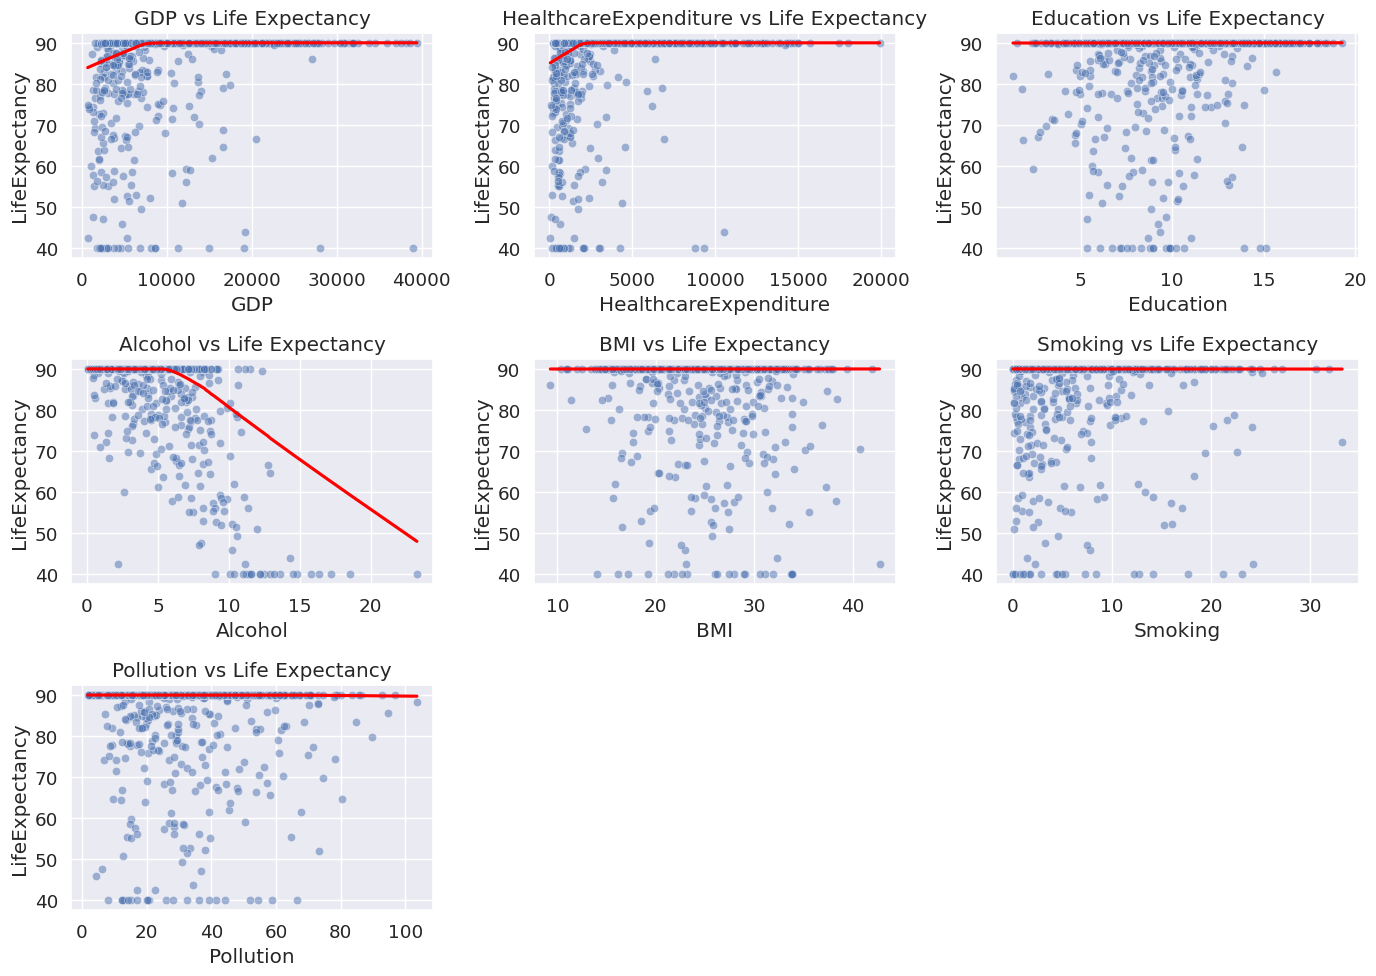

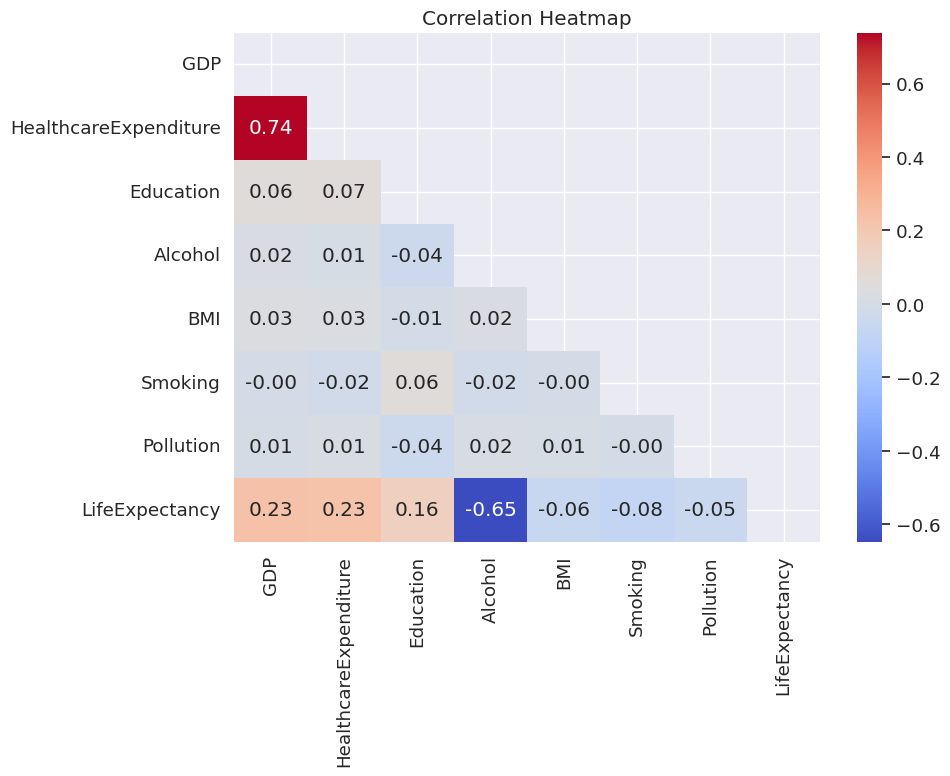


Building Generalized Additive Model (GAM)...
Train RMSE: 4.73
Test RMSE: 6.21
Train R²: 0.7979
Test R²: 0.5691

Visualizing GAM model results...


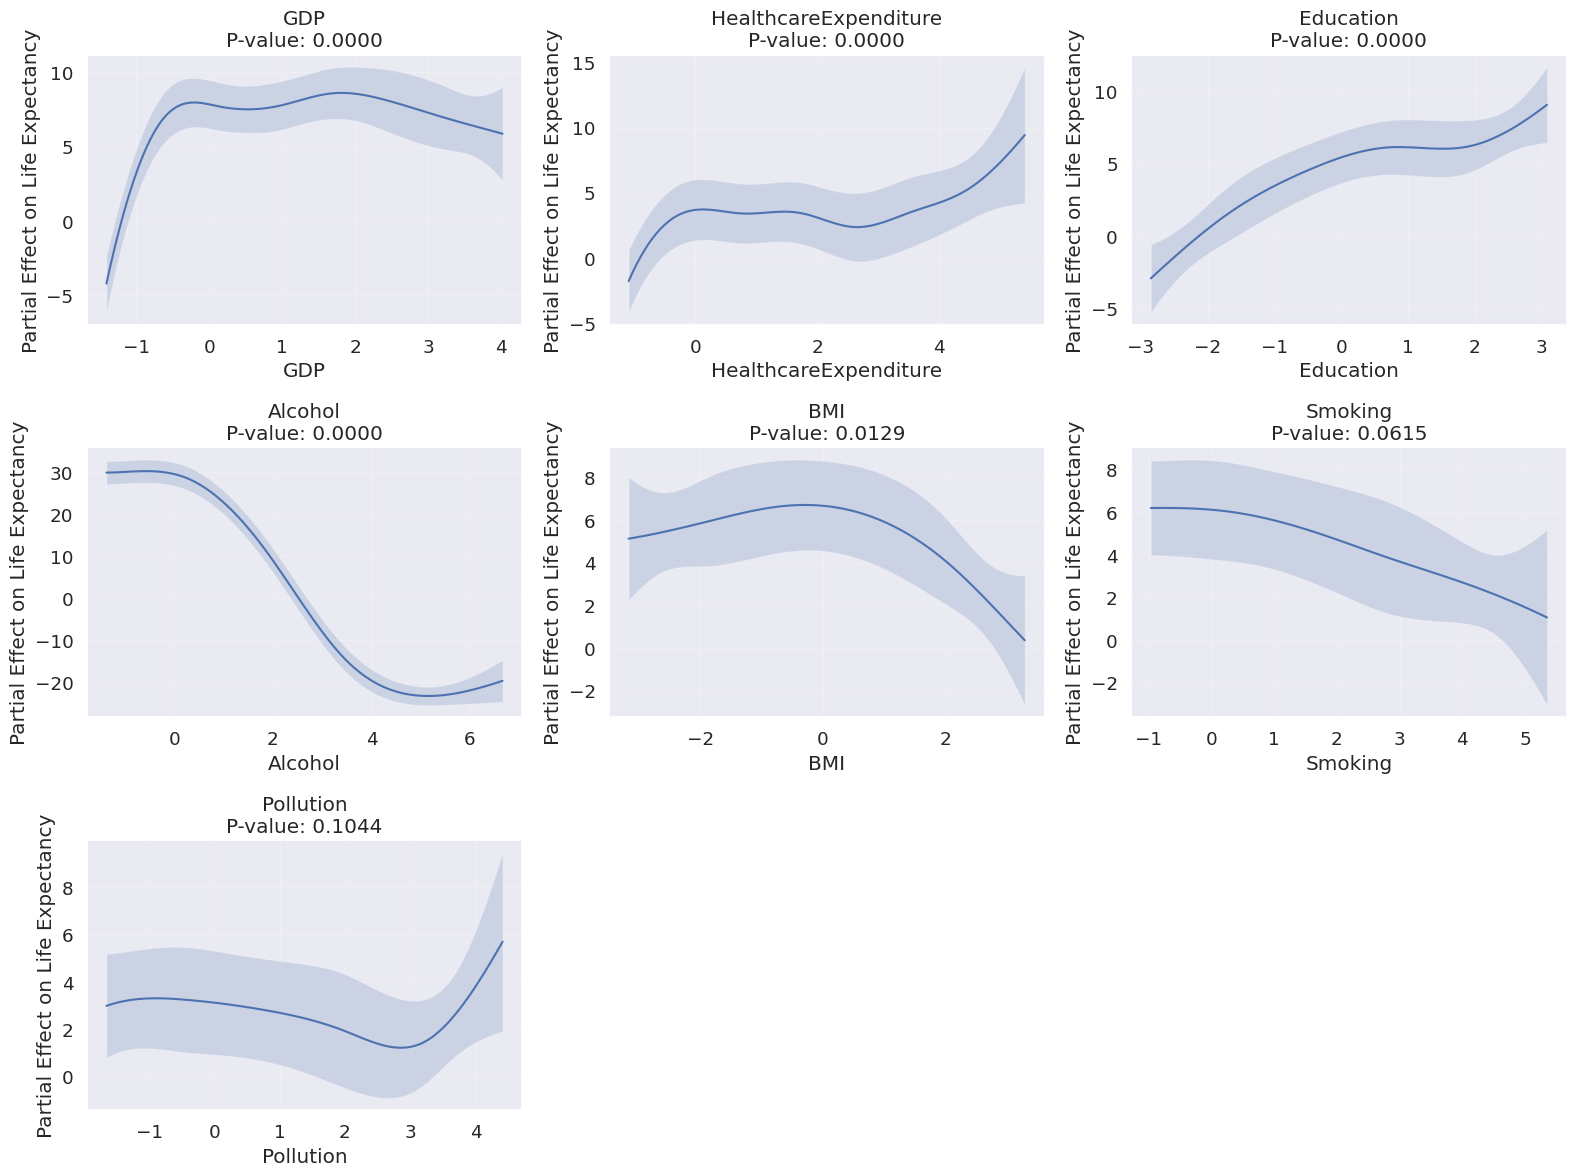

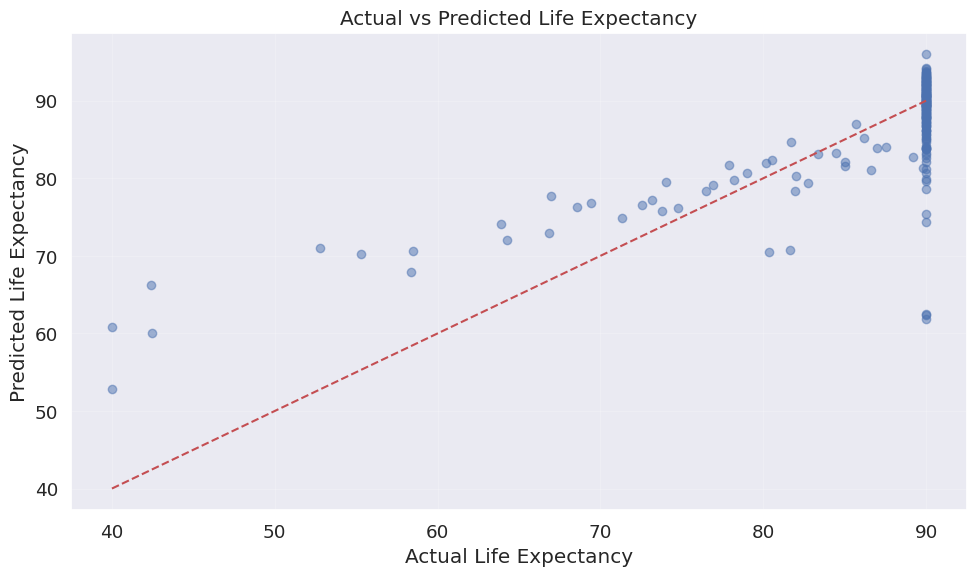

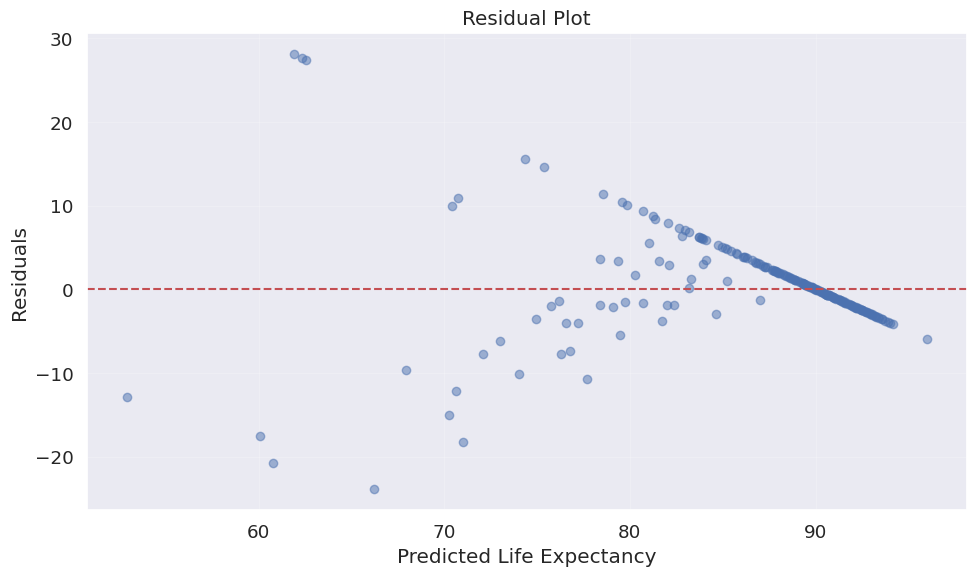

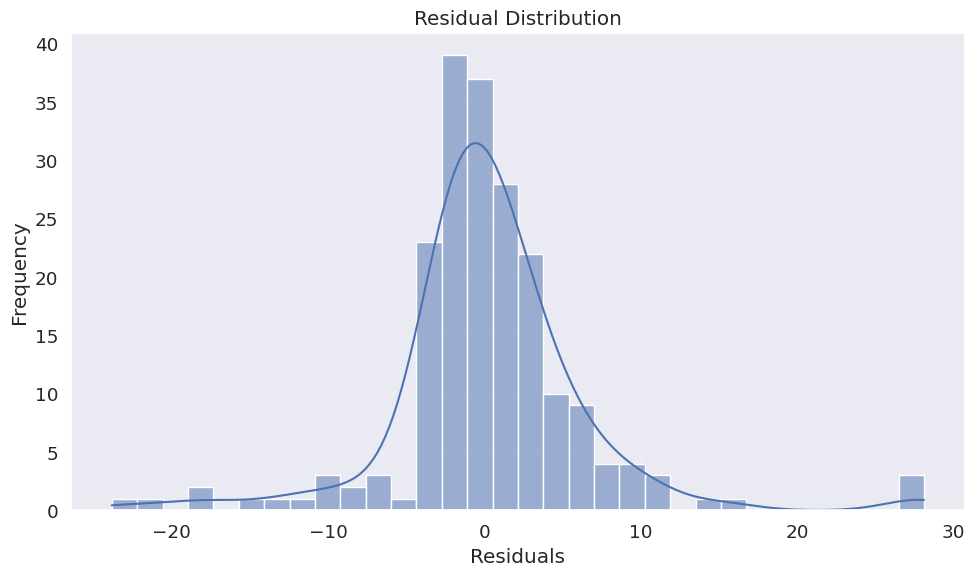


GAM Model Summary:
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     31.6485
Link Function:                     IdentityLink Log Likelihood:                                 -3271.5368
Number of Samples:                          800 AIC:                                             6608.3705
                                                AICc:                                            6611.2375
                                                GCV:                                               25.1157
                                                Scale:                                             23.3338
                                                Pseudo R-Squared:                                   0.7979
Feature Function 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LinearGAM, s, f, te
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
np.int = np.int32
# Set the style for our plots
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# Load your dataset
# Replace 'your_dataset.csv' with your actual file path
# df = pd.read_csv('your_dataset.csv')

# For demonstration, I'll create a sample dataset similar to WHO life expectancy data
# In your actual implementation, replace this with your data loading code
np.random.seed(42)
n_samples = 1000

# Create synthetic features that might affect life expectancy
gdp = np.random.gamma(shape=2, scale=5000, size=n_samples) + 500
healthcare_exp = gdp * (np.random.beta(2, 5, size=n_samples) + 0.02)
education = np.random.normal(10, 3, size=n_samples)
alcohol = np.random.gamma(2, scale=2, size=n_samples)
bmi = np.random.normal(25, 5, size=n_samples)
smoking = np.random.gamma(1, scale=5, size=n_samples)
pollution = np.random.gamma(3, scale=10, size=n_samples)

# Create non-linear effects for life expectancy
life_exp_base = 50
gdp_effect = 10 * np.log(gdp/500)
healthcare_effect = 5 * np.sqrt(healthcare_exp/100)
education_effect = 0.5 * education**1.5
alcohol_effect = -0.5 * alcohol**2
bmi_effect = -0.05 * (bmi - 22)**2
smoking_effect = -0.2 * smoking**1.2
pollution_effect = -0.1 * pollution

# Add some interaction effects
interaction_effect = 0.01 * np.sqrt(gdp * education)

# Combine effects with some noise
life_expectancy = (life_exp_base + gdp_effect + healthcare_effect +
                  education_effect + alcohol_effect + bmi_effect +
                  smoking_effect + pollution_effect + interaction_effect +
                  np.random.normal(0, 1, size=n_samples))

# Ensure life expectancy values are reasonable
life_expectancy = np.clip(life_expectancy, 40, 90)

# Create DataFrame
df = pd.DataFrame({
    'GDP': gdp,
    'HealthcareExpenditure': healthcare_exp,
    'Education': education,
    'Alcohol': alcohol,
    'BMI': bmi,
    'Smoking': smoking,
    'Pollution': pollution,
    'LifeExpectancy': life_expectancy
})

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nSample of the dataset:")
print(df.head())
print("\nDataset summary statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Exploratory Data Analysis
print("\nPerforming Exploratory Data Analysis...")

# Set up a figure for our exploratory plots
plt.figure(figsize=(14, 10))

# Create scatter plots with trend lines to visualize non-linear relationships
for i, column in enumerate(['GDP', 'HealthcareExpenditure', 'Education', 'Alcohol', 'BMI', 'Smoking', 'Pollution']):
    plt.subplot(3, 3, i+1)
    sns.scatterplot(x=column, y='LifeExpectancy', data=df, alpha=0.5)

    # Add a LOWESS trend line to visualize the relationship
    sns.regplot(x=column, y='LifeExpectancy', data=df, scatter=False,
                lowess=True, line_kws={'color': 'red'})

    plt.title(f'{column} vs Life Expectancy')
    plt.tight_layout()

plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation = df.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, cmap='coolwarm', mask=mask, fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Prepare data for modeling
X = df.drop('LifeExpectancy', axis=1)
y = df['LifeExpectancy']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to pandas DataFrame to preserve column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns,dtype=np.float64)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns,dtype=np.float64)

print("\nBuilding Generalized Additive Model (GAM)...")

# Build a GAM model
# s() is used for smoothing splines
# We'll apply different spline functions based on the expected relationship
gam = LinearGAM(
    s(0, n_splines=10) +  # GDP (0-indexed)
    s(1, n_splines=10) +  # HealthcareExpenditure
    s(2, n_splines=8) +   # Education
    s(3, n_splines=8) +   # Alcohol
    s(4, n_splines=8) +   # BMI
    s(5, n_splines=8) +   # Smoking
    s(6, n_splines=8)     # Pollution
    # Removing the tensor product interaction which causes the sparse matrix error
)

# Fit the model
gam.fit(X_train_scaled, y_train)

# Make predictions
y_pred_train = gam.predict(X_train_scaled)
y_pred_test = gam.predict(X_test_scaled)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Visualize partial dependence plots for each feature
print("\nVisualizing GAM model results...")
plt.figure(figsize=(16, 12))

for i, term in enumerate(['GDP', 'HealthcareExpenditure', 'Education',
                         'Alcohol', 'BMI', 'Smoking', 'Pollution']):
    plt.subplot(3, 3, i+1)

    # Get the partial dependence data for this feature
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    # Plot partial dependence
    plt.plot(XX[:, i], pdep)
    plt.fill_between(XX[:, i], confi[:, 0], confi[:, 1], alpha=0.2)

    # Add feature importance as a title
    importance = gam.statistics_['p_values'][i]
    plt.title(f'{term}\nP-value: {importance:.4f}')

    plt.xlabel(term)
    plt.ylabel('Partial Effect on Life Expectancy')
    plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.title('Actual vs Predicted Life Expectancy')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# Visualize the residuals
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Life Expectancy')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# Distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

print("\nGAM Model Summary:")
print(gam.summary())

print("\nAnalysis complete!")
print("To apply this to your actual dataset, replace the sample data generation with your data loading code.")
print("You may need to adjust the feature names and model parameters based on your specific dataset.")

In [ ]:
file_path = "Life Expectancy Data.csv"  # Update this with your actual file path
df = pd.read_csv(file_path)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

Mean Squared Error (Bagging): 3.6374
Mean Squared Error (Random Forest): 3.6343
Mean Squared Error (Gradient Boosting): 4.8608


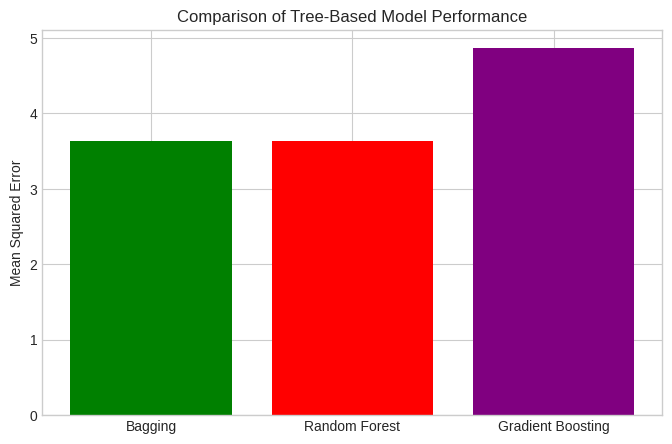

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Load dataset
file_path = "Life Expectancy Data.csv"  # Update this with your actual file path
df = pd.read_csv(file_path)

# Drop categorical columns and rows with missing values
df_numeric = df.drop(columns=['Country', 'Status']).dropna()

# Define features and target
X = df_numeric.drop(columns=['Life expectancy '])
y = df_numeric['Life expectancy ']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tree-based methods
# Bagging
bagging_model = BaggingRegressor(n_estimators=100, random_state=42)
bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)
mse_bagging = mean_squared_error(y_test, y_pred_bagging)
print(f'Mean Squared Error (Bagging): {mse_bagging:.4f}')

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Mean Squared Error (Random Forest): {mse_rf:.4f}')

# Boosting (Gradient Boosting)
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
print(f'Mean Squared Error (Gradient Boosting): {mse_gb:.4f}')

# Plot comparisons
models = ['Bagging', 'Random Forest', 'Gradient Boosting']
mse_values = [mse_bagging, mse_rf, mse_gb]

plt.figure(figsize=(8, 5))
plt.bar(models, mse_values, color=['green', 'red', 'purple'])
plt.ylabel('Mean Squared Error')
plt.title('Comparison of Tree-Based Model Performance')
plt.show()

Mean Squared Error (SVM - linear kernel): 13.6260
Mean Squared Error (SVM - poly kernel): 27.6762
Mean Squared Error (SVM - rbf kernel): 11.6239
Mean Squared Error (SVM - sigmoid kernel): 58.9209


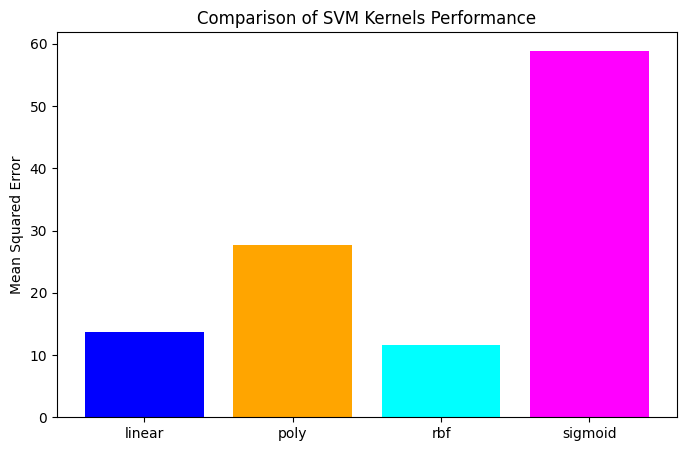

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Load dataset
file_path = "Life Expectancy Data.csv"  # Update this with your actual file path
df = pd.read_csv(file_path)

# Drop categorical columns and rows with missing values
df_numeric = df.drop(columns=['Country', 'Status']).dropna()

# Define features and target
X = df_numeric.drop(columns=['Life expectancy '])
y = df_numeric['Life expectancy ']

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reduce dataset size for faster training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, train_size=0.5)

# SVM with different kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
mse_svm = {}

for kernel in kernels:
    svm_model = SVR(kernel=kernel, cache_size=7000)
    svm_model.fit(X_train, y_train)
    y_pred_svm = svm_model.predict(X_test)
    mse_svm[kernel] = mean_squared_error(y_test, y_pred_svm)
    print(f'Mean Squared Error (SVM - {kernel} kernel): {mse_svm[kernel]:.4f}')

# Plot comparisons
plt.figure(figsize=(8, 5))
plt.bar(kernels, list(mse_svm.values()), color=['blue', 'orange', 'cyan', 'magenta'])
plt.ylabel('Mean Squared Error')
plt.title('Comparison of SVM Kernels Performance')
plt.show()